# Find the customer segments

We have been tasked with identifying customer segments and delivering insight about our data in general, and about these clusters.

This is a real-world technique that can have a direct effect on how businesses behave towards their customers.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import missingno
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.dpi'] = 200
sns.set_style("white")

In [3]:
df = pd.read_csv('Clustering/Mall_Customers.csv')

df.head()

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [5]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

<Axes: >

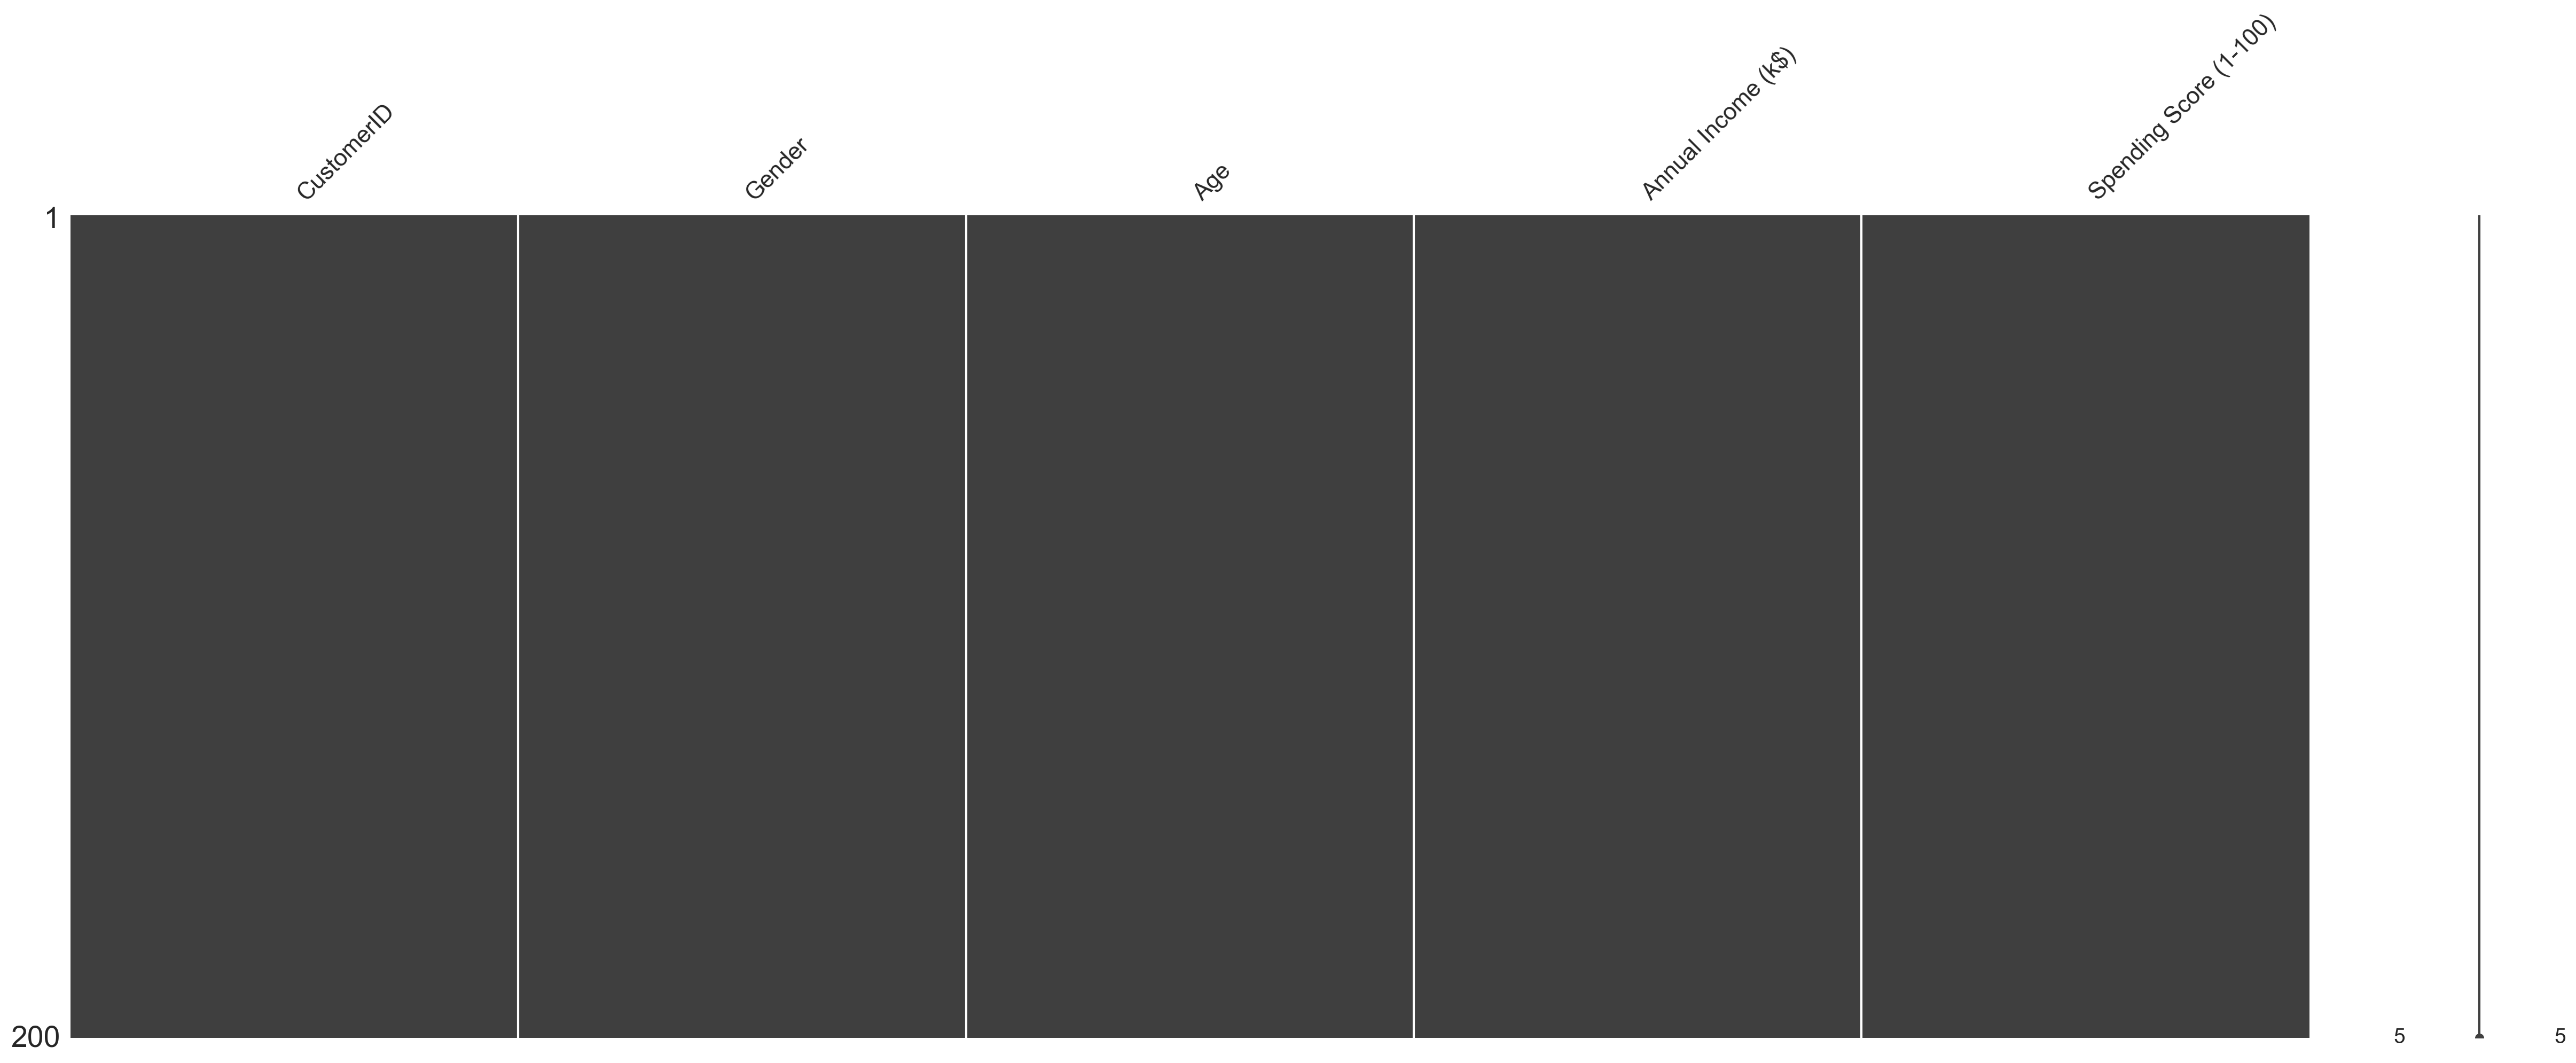

In [6]:
missingno.matrix(df, figsize = (30,10))

There are no missing value or have NaN so I will do explorative data analysis through visualization

## Explorative Data Analysis

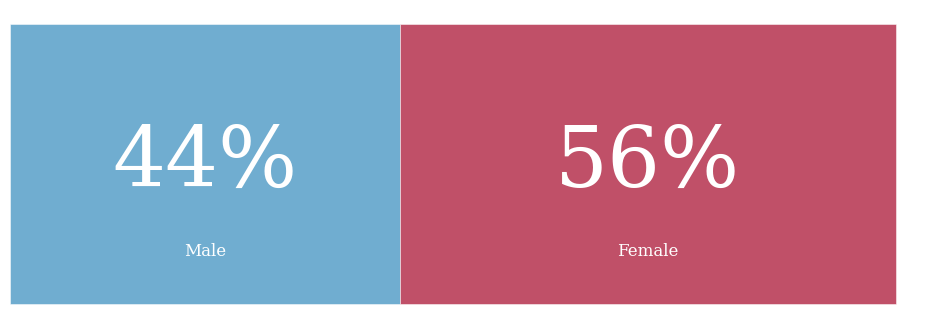

In [203]:
def plot_ratio(df):
    x = (df.groupby(by=['Gender'])['Gender'].count())/len(df)
    ratio = pd.DataFrame(x).T

    fig, ax = plt.subplots(1,1, figsize= (12,4), dpi=100)
    ax.barh(ratio.index, ratio['Male'], 
            alpha=0.7, label='Male')
    
    ax.barh(ratio.index, ratio['Female'], left=ratio['Male'], 
            alpha=0.7, label='Female')


    for i in ratio.index:
        ax.annotate(f"{int(ratio['Female'][i]*100)}%", 
                       xy=(ratio['Male'][i]+ratio['Female'][i]/2, i),
                       va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                       color='white')
        ax.annotate("Female", 
                       xy=(ratio['Male'][i]+ratio['Female'][i]/2, -0.25),
                       va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='white')
        
    for i in ratio.index:
        ax.annotate(f"{int(ratio['Male'][i]*100)}%", 
                       xy=(ratio['Male'][i]/2, i),
                    va = 'center', ha='center',fontsize=60, fontweight='light', fontfamily='serif',
                       color='white')

        ax.annotate("Male", 
                       xy=(ratio['Male'][i]/2, -0.25),
                       va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='white')
    # Turn off all ax labels,ticks and spines
    ax.set_axis_off()

    # Removing legend due to labelled plot
    ax.legend().set_visible(False)
    plt.savefig("Clustering/images/sex_ratio", bbox_inches='tight', dpi=300)
    plt.show()
    
plot_ratio(df)

In [8]:
cluster = df.copy()
cluster = cluster.drop(columns=['CustomerID'])
cluster.describe().T

count   mean        std   min    25%   50%   75%  \
Age                     200.0  38.85  13.969007  18.0  28.75  36.0  49.0   
Annual Income (k$)      200.0  60.56  26.264721  15.0  41.50  61.5  78.0   
Spending Score (1-100)  200.0  50.20  25.823522   1.0  34.75  50.0  73.0   

                          max  
Age                      70.0  
Annual Income (k$)      137.0  
Spending Score (1-100)   99.0

### Findings
There are some outliners in our dataset. However, in the case of clustering, we don't remove variables in features as we want to find their relationships. Hence, removing variables in this stage might introducing bias later in our findings.

<Axes: ylabel='Frequency'>

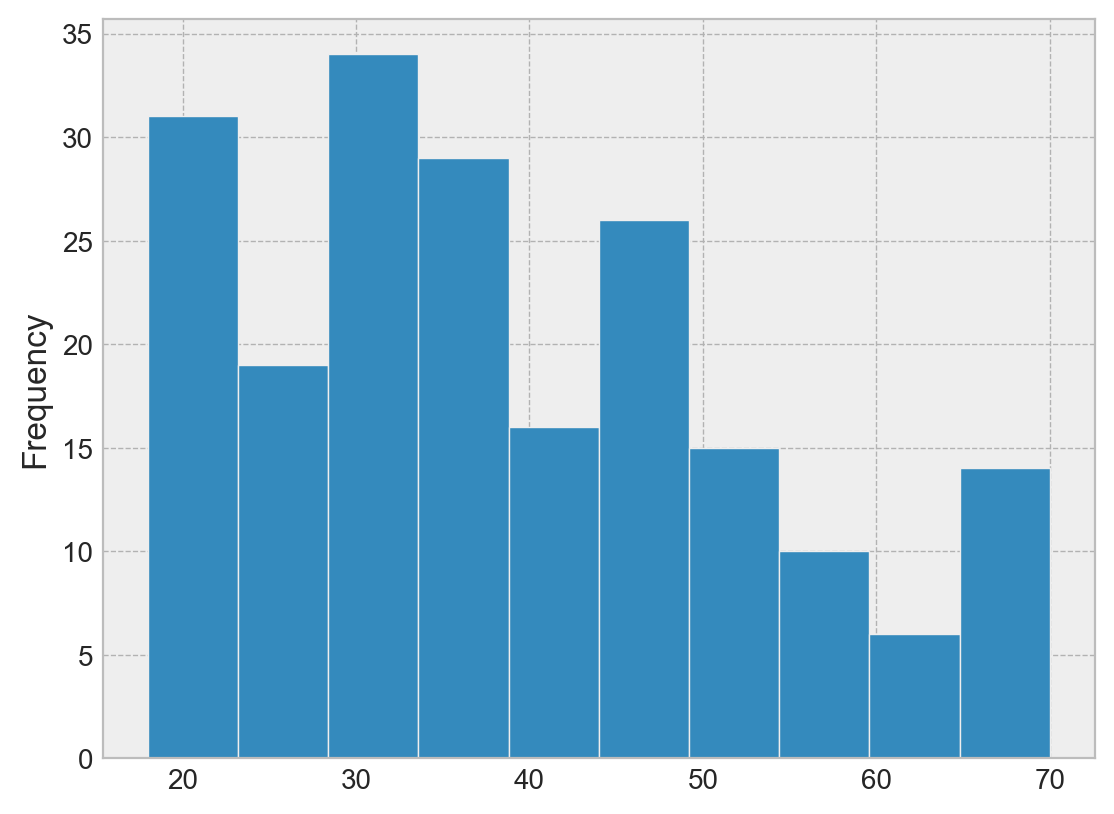

In [9]:
cluster.Age.plot.hist()

## Distribution Plots

In [10]:
cluster['Age'].sort_values().unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 68, 69, 70])

In [11]:
# Create age range 
def age_range(num):
    for i in range(1, 100):
        if num < 10*i :  return f'{(i-1) * 10} ~ {i*10}'

cluster['age_range'] = cluster['Age'].apply(age_range)
cluster = cluster.sort_values(by ='age_range', ascending=True)


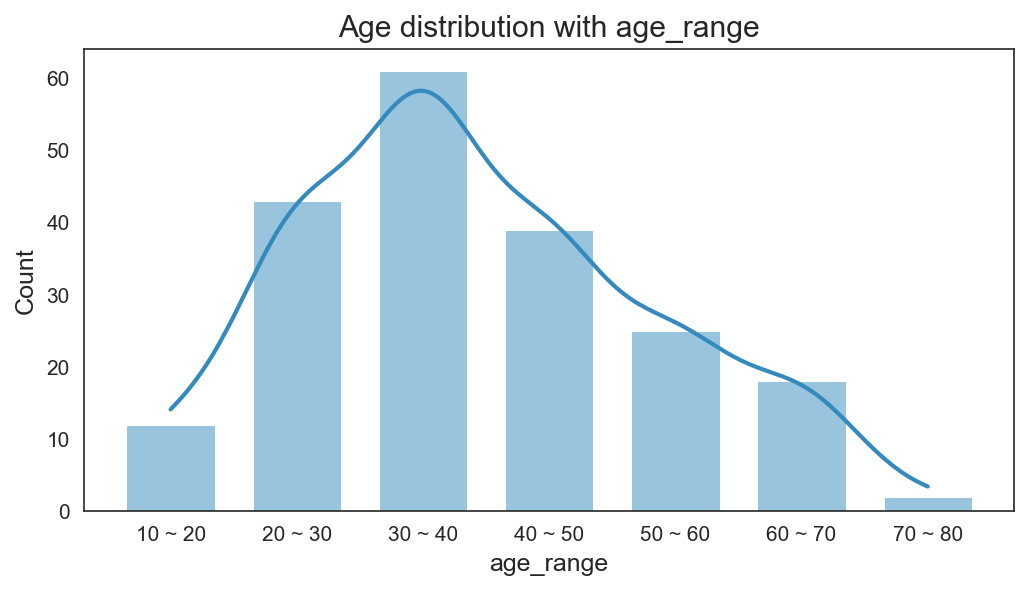

In [12]:
plt.figure(dpi=150, figsize=(8,4))
sns.set_style("white")
sns.histplot(cluster,
            x='age_range',
             kde=True,
             palette='bmh',  shrink=.7, color='C0')
            
plt.title('Age distribution with age_range')
plt.show()

# Age and Gender Distribution

In [13]:
#tempo_range_age 
cluster.groupby('Gender').age_range.value_counts().unstack().fillna(0).astype(int)


age_range  10 ~ 20  20 ~ 30  30 ~ 40  40 ~ 50  50 ~ 60  60 ~ 70  70 ~ 80
Gender                                                                  
Female           3       26       37       24       14        8        0
Male             9       17       24       15       11       10        2

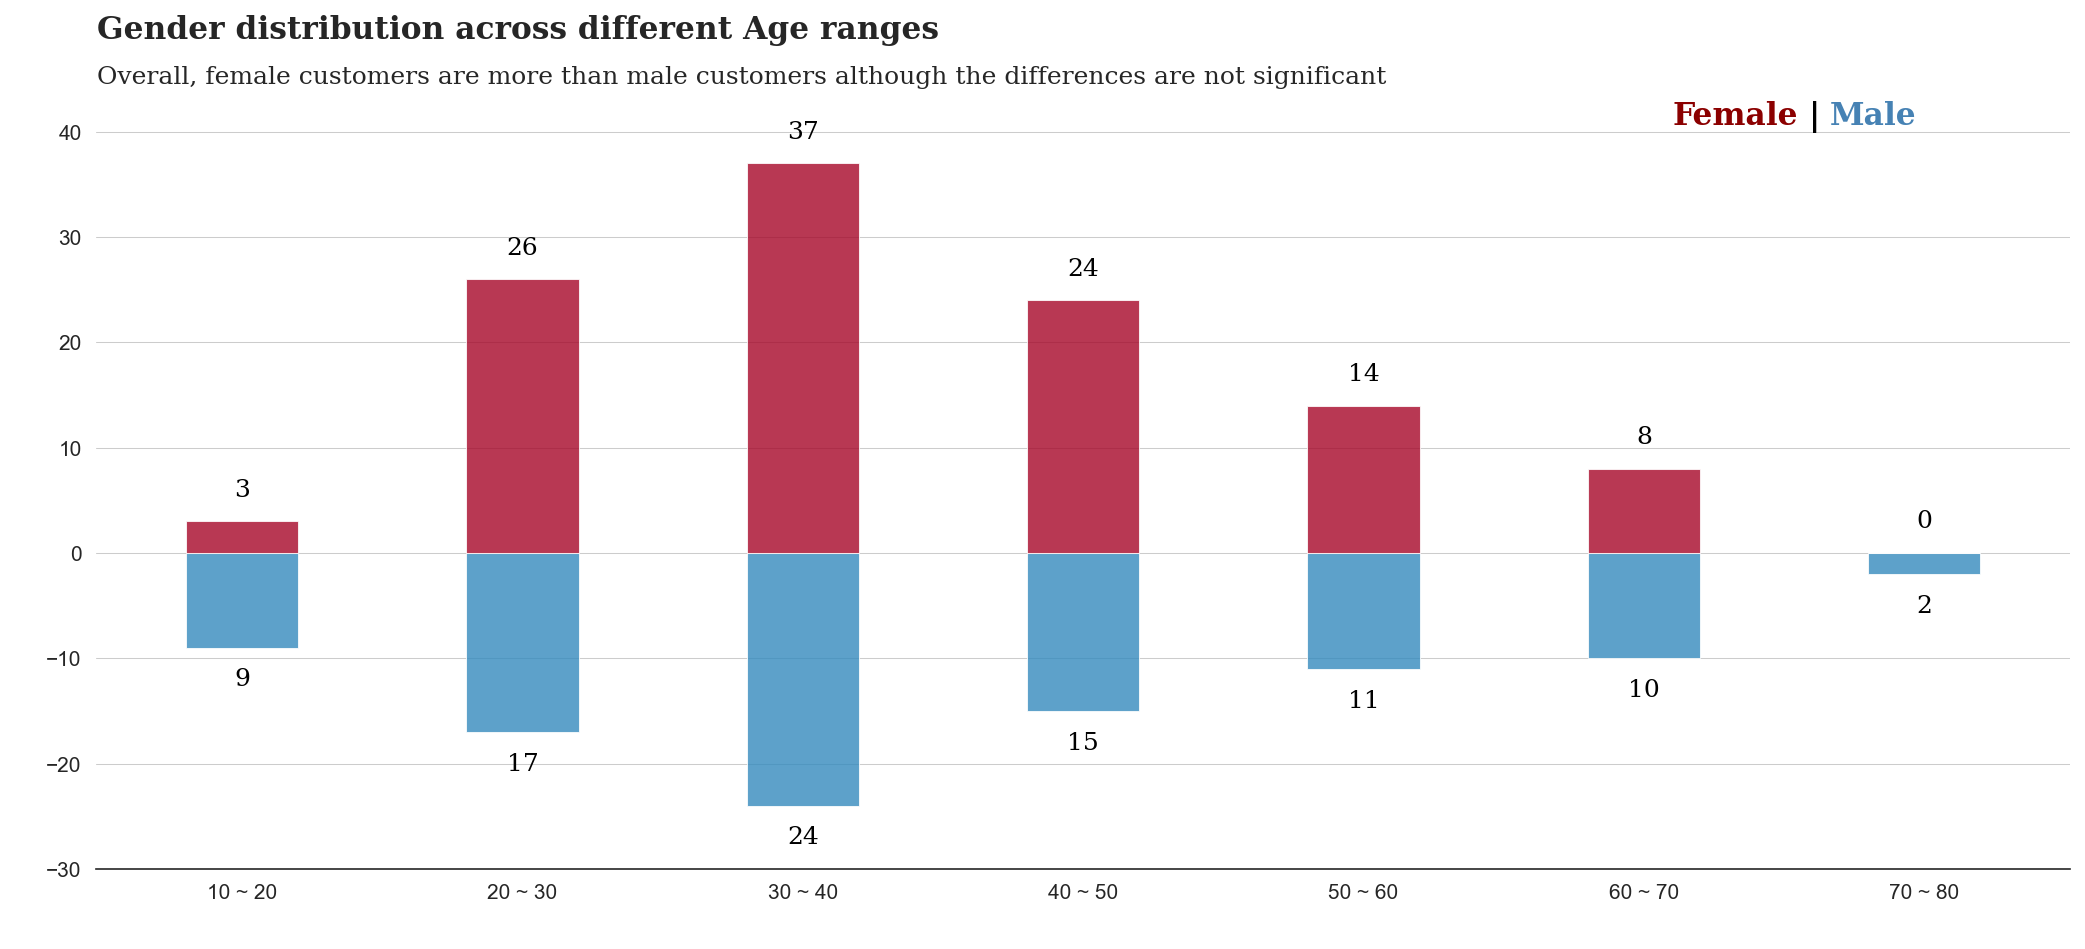

In [204]:
def age_gender_plot(cluster):
    age_range_gender = cluster.groupby(['Gender']).age_range.value_counts().unstack().fillna(0).astype(int)
    
    male = - age_range_gender.loc['Male']
    female = age_range_gender.loc['Female']

    fig, ax = plt.subplots(figsize=(14,6), dpi=150, facecolor='white')
    fig.text(0.05, 1.02, 'Gender distribution across different Age ranges', fontsize=15, fontweight='bold', fontfamily='serif')
    fig.text(0.05, .97, 'Overall, female customers are more than male customers although the differences are not significant', fontsize=12,
             fontweight='light', fontfamily='serif')
    ax.bar(male.index, male, alpha=0.8, width=0.4, label= 'Male')
    ax.bar(female.index, female, alpha=0.8, width=0.4, label= 'Female')
    
    ax.set_xlabel(" ")
    ax.set_ylabel(' ')
    ax.set_xticks(male.index)
    ax.set_ylim(-30,45)
    ax.spines[['right', 'top','left']].set_visible(False)

    plt.grid(visible=True, axis="y")
    ax.legend().set_visible(False)

    for i in female.index:
        ax.annotate(f"{int(female[i])}", 
                       xy=(i, female[i] + 3),
                       va ='center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='black')
        
    for i in male.index:
        ax.annotate(f"{-male[i]}", 
                       xy=(i, male[i] - 3),
                       va ='center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                       color='black')

    fig.text(0.8,0.924,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='darkred')
    fig.text(0.865,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
    fig.text(0.875,0.924,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='steelblue')

    plt.tight_layout()
    plt.savefig("Clustering/images/gender_range", bbox_inches='tight', dpi=300)
    plt.show()

age_gender_plot(cluster)

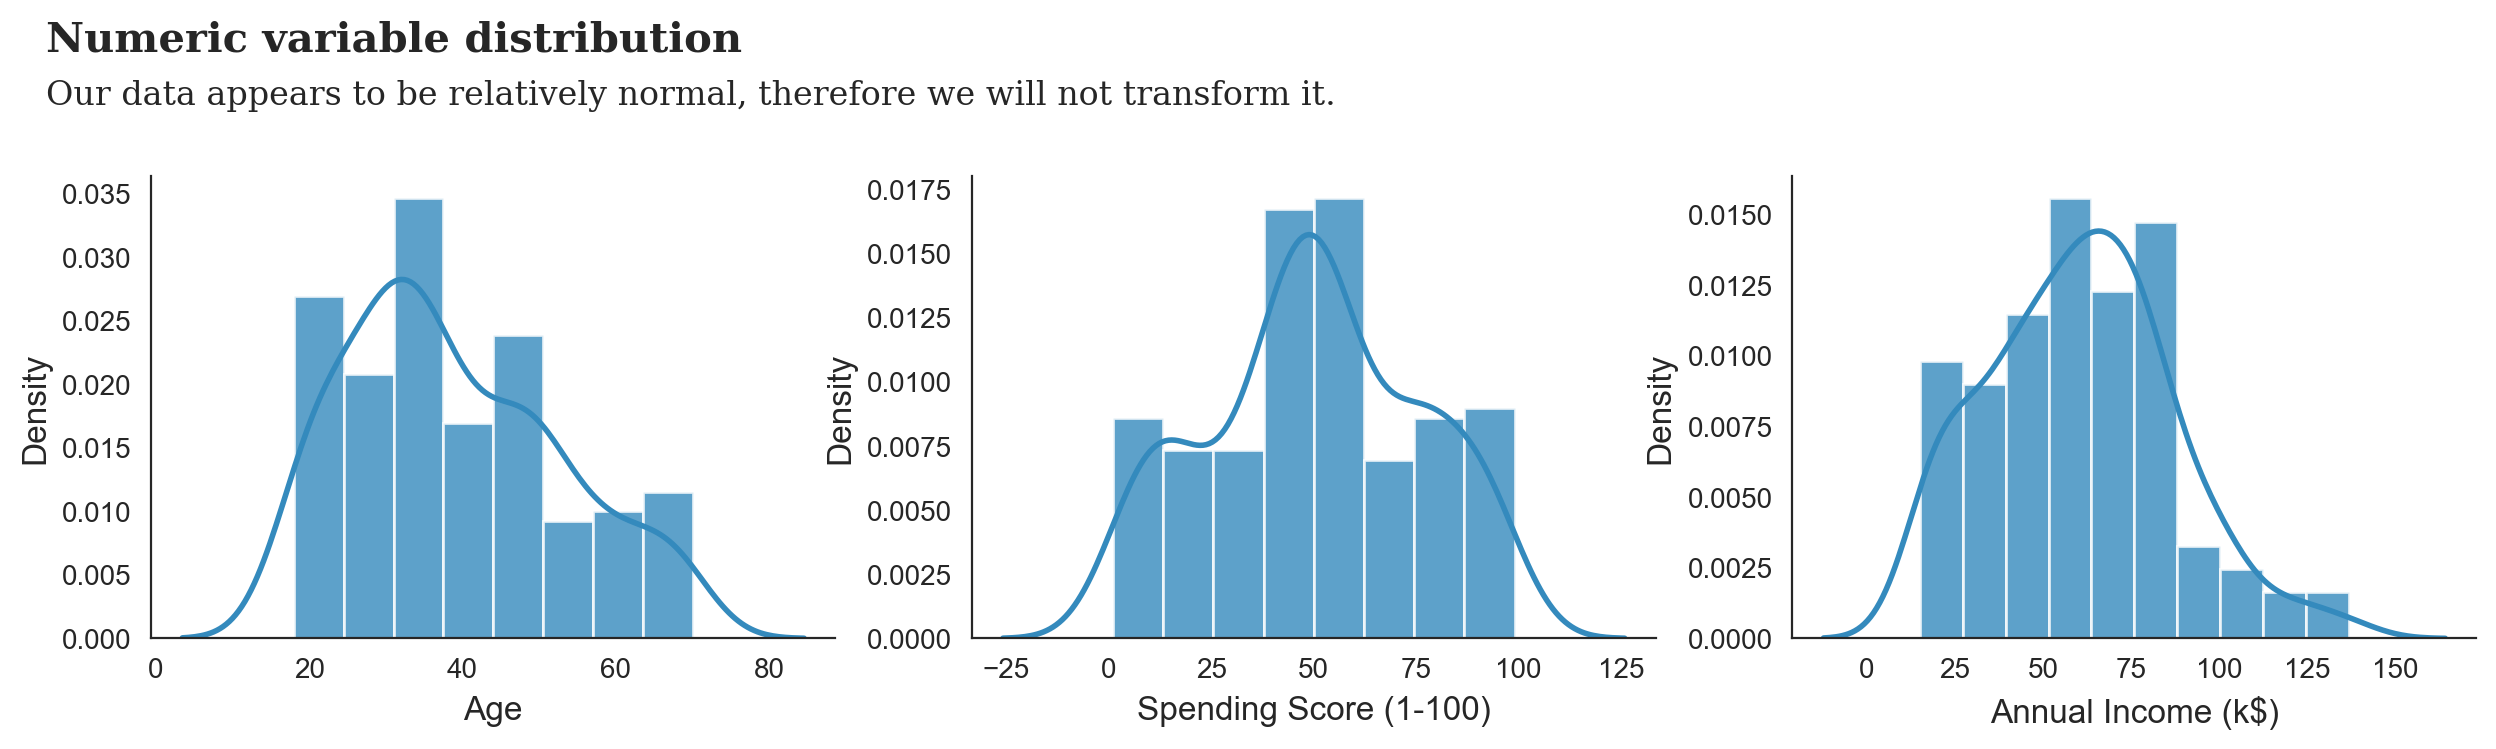

In [142]:
fig = plt.figure(figsize=(15, 3)) 
index = 1


fig.text(0.09, 1.09, 'Numeric variable distribution', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 1, 'Our data appears to be relatively normal, therefore we will not transform it.', fontsize=12, fontweight='light', fontfamily='serif')

         
for i in [ 'Age', "Spending Score (1-100)","Annual Income (k$)"]: 
    plt.subplot(1, 3, index) 
    sns.distplot(cluster[i],hist_kws=dict(edgecolor="white", linewidth=1,alpha=0.8))
    sns.despine()
    index += 1
plt.savefig("Clustering/images/numeric_dist", bbox_inches='tight', dpi=300)
plt.show()

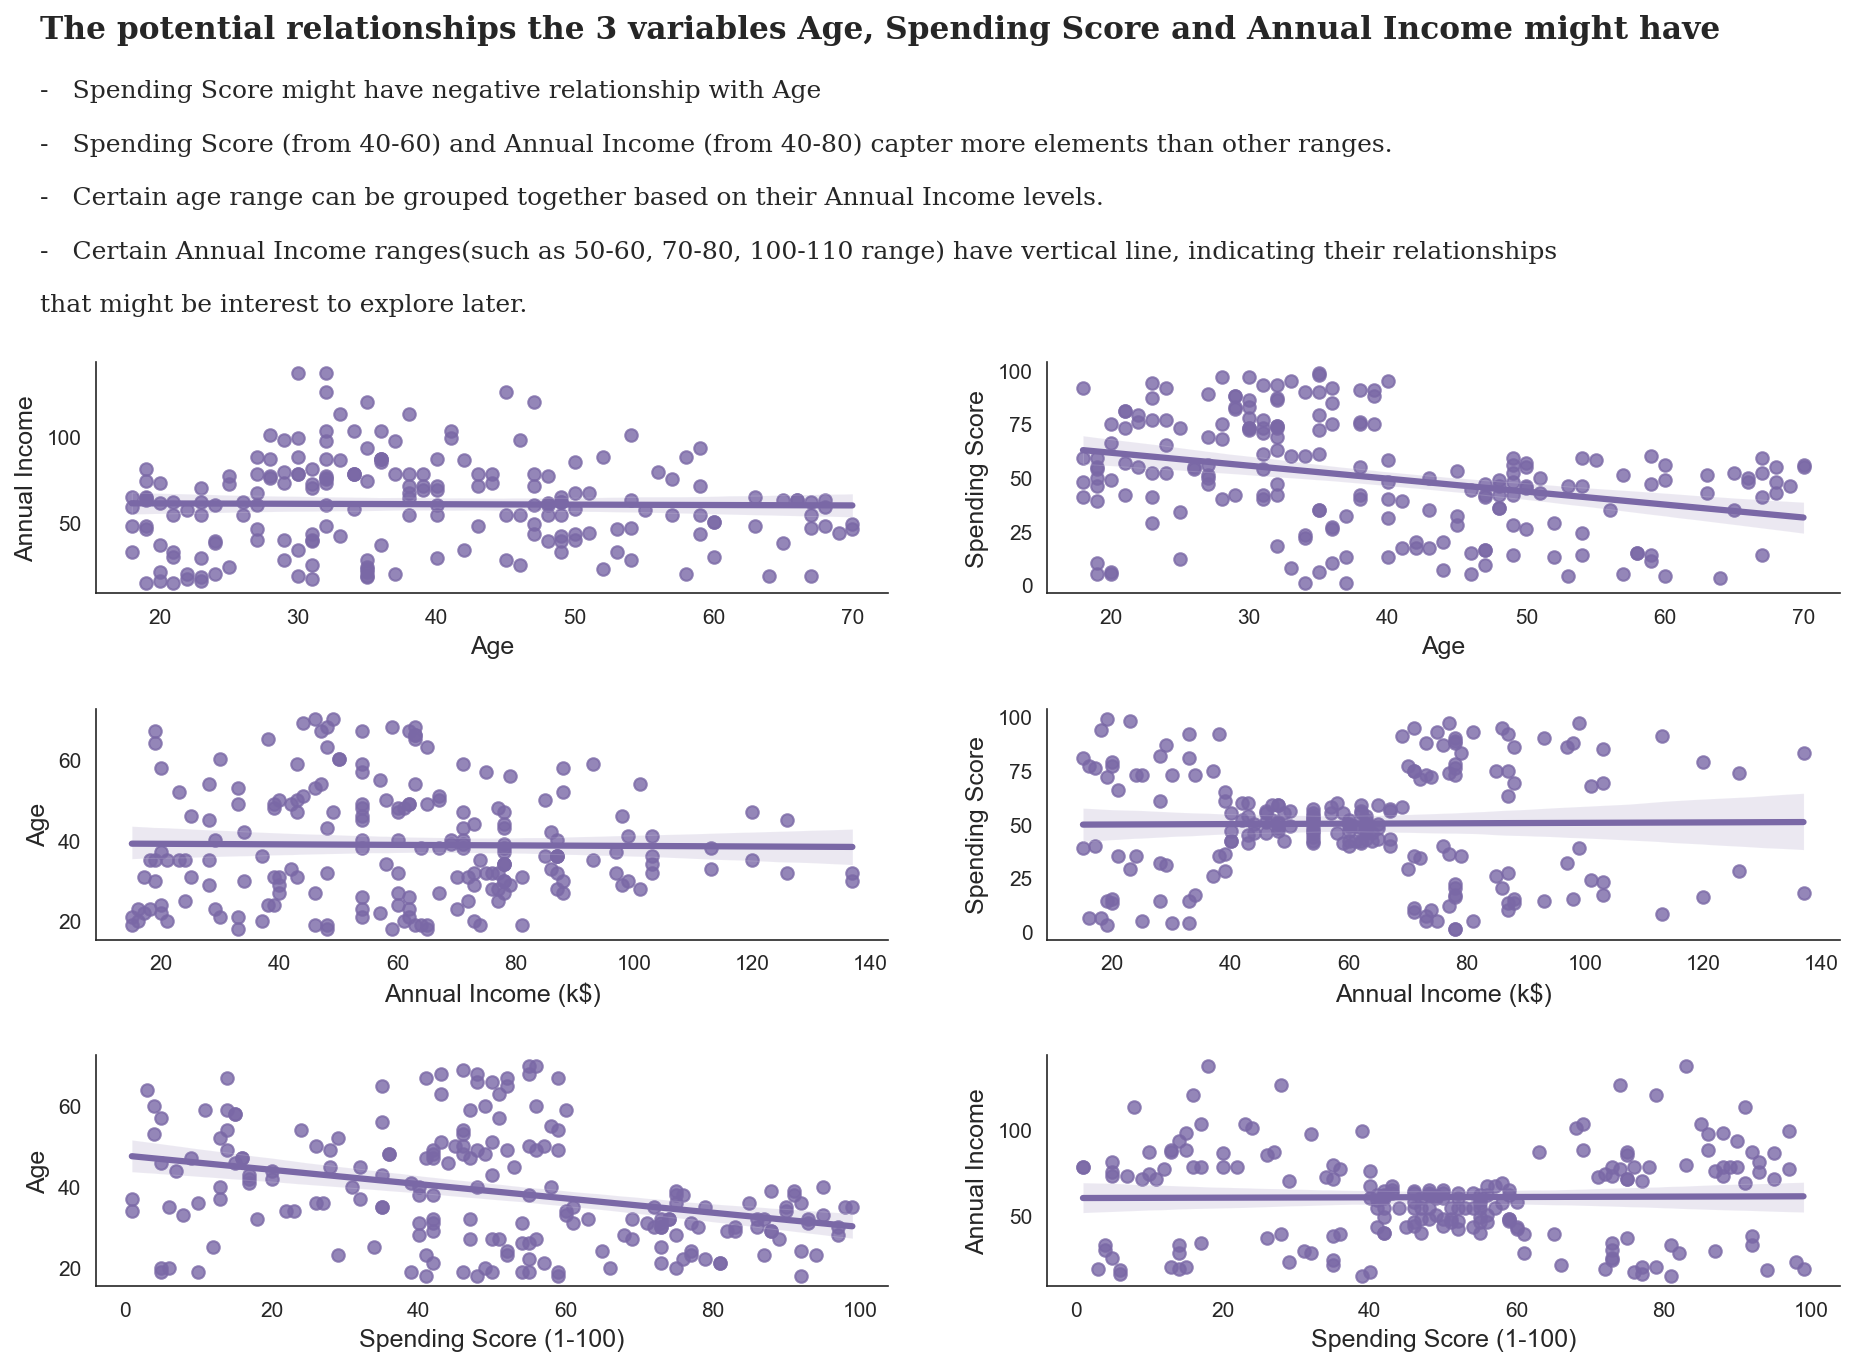

In [149]:
fig = plt.figure(figsize=(15, 8), dpi=150) 
index = 1

fig.text(0.1, 1.15, 'The potential relationships the 3 variables Age, Spending Score and Annual Income might have', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.1, .90, '''
-   Spending Score might have negative relationship with Age

-   Spending Score (from 40-60) and Annual Income (from 40-80) capter more elements than other ranges.

-   Certain age range can be grouped together based on their Annual Income levels.

-   Certain Annual Income ranges(such as 50-60, 70-80, 100-110 range) have vertical line, indicating their relationships 

that might be interest to explore later.
''', fontsize=12, fontweight='light', fontfamily='serif')

for x in sorted(['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']):
    for y in sorted(['Spending Score (1-100)','Age' , 'Annual Income (k$)']):
        if x==y: continue
    
        plt.subplot(3 , 2 , index)
        plt.subplots_adjust(hspace = 0.5)
        sns.regplot(x = x , y = y , data = cluster, color='C2')
        sns.despine()
     
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 
                   else y )
        index +=1
plt.savefig("Clustering/images/dist_relationship", bbox_inches='tight', dpi=300)
plt.show()


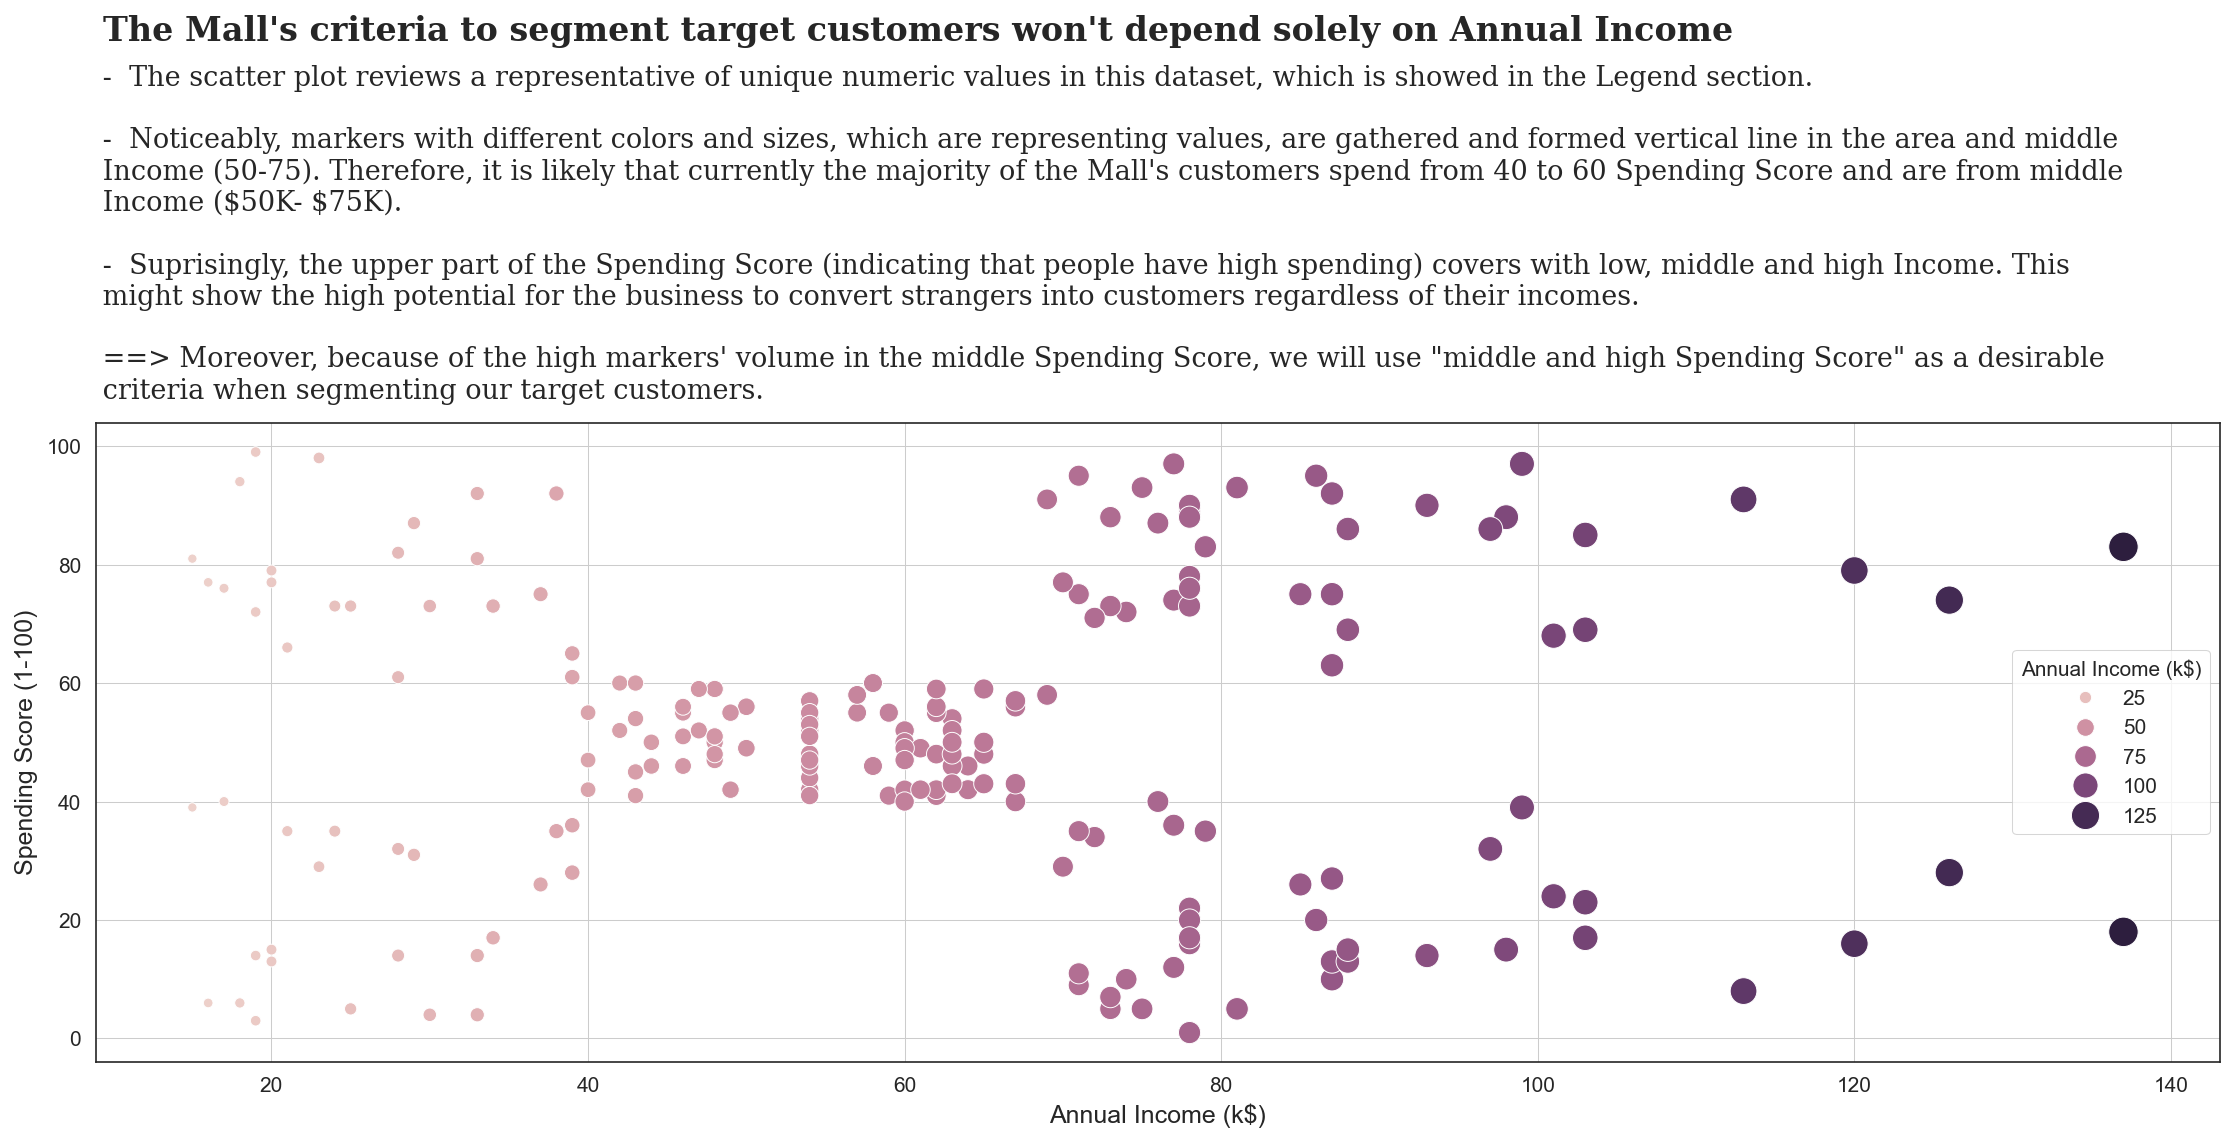

In [205]:
fig=plt.figure(figsize=(15,5), dpi=150)

fig.text(0.049, 1.48, "The Mall's criteria to segment target customers won't depend solely on Annual Income", fontsize=16, fontweight='bold', fontfamily='serif')
fig.text(0.045, .92, '''
 -  The scatter plot reviews a representative of unique numeric values in this dataset, which is showed in the Legend section.

 -  Noticeably, markers with different colors and sizes, which are representing values, are gathered and formed vertical line in the area and middle 
 Income (50-75). Therefore, it is likely that currently the majority of the Mall's customers spend from 40 to 60 Spending Score and are from middle 
 Income (\$50K- \$75K).
 
 -  Suprisingly, the upper part of the Spending Score (indicating that people have high spending) covers with low, middle and high Income. This 
 might show the high potential for the business to convert strangers into customers regardless of their incomes.
 
 ==> Moreover, because of the high markers' volume in the middle Spending Score, we will use "middle and high Spending Score" as a desirable 
 criteria when segmenting our target customers.

''',  fontsize=13, fontweight='light', fontfamily='serif')
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',data=cluster,
                size='Annual Income (k$)',sizes=(20, 200), hue='Annual Income (k$)')
plt.grid(True)
plt.tight_layout()
plt.savefig("Clustering/images/spend_income_scatterplot", bbox_inches='tight', dpi=300)
plt.show()

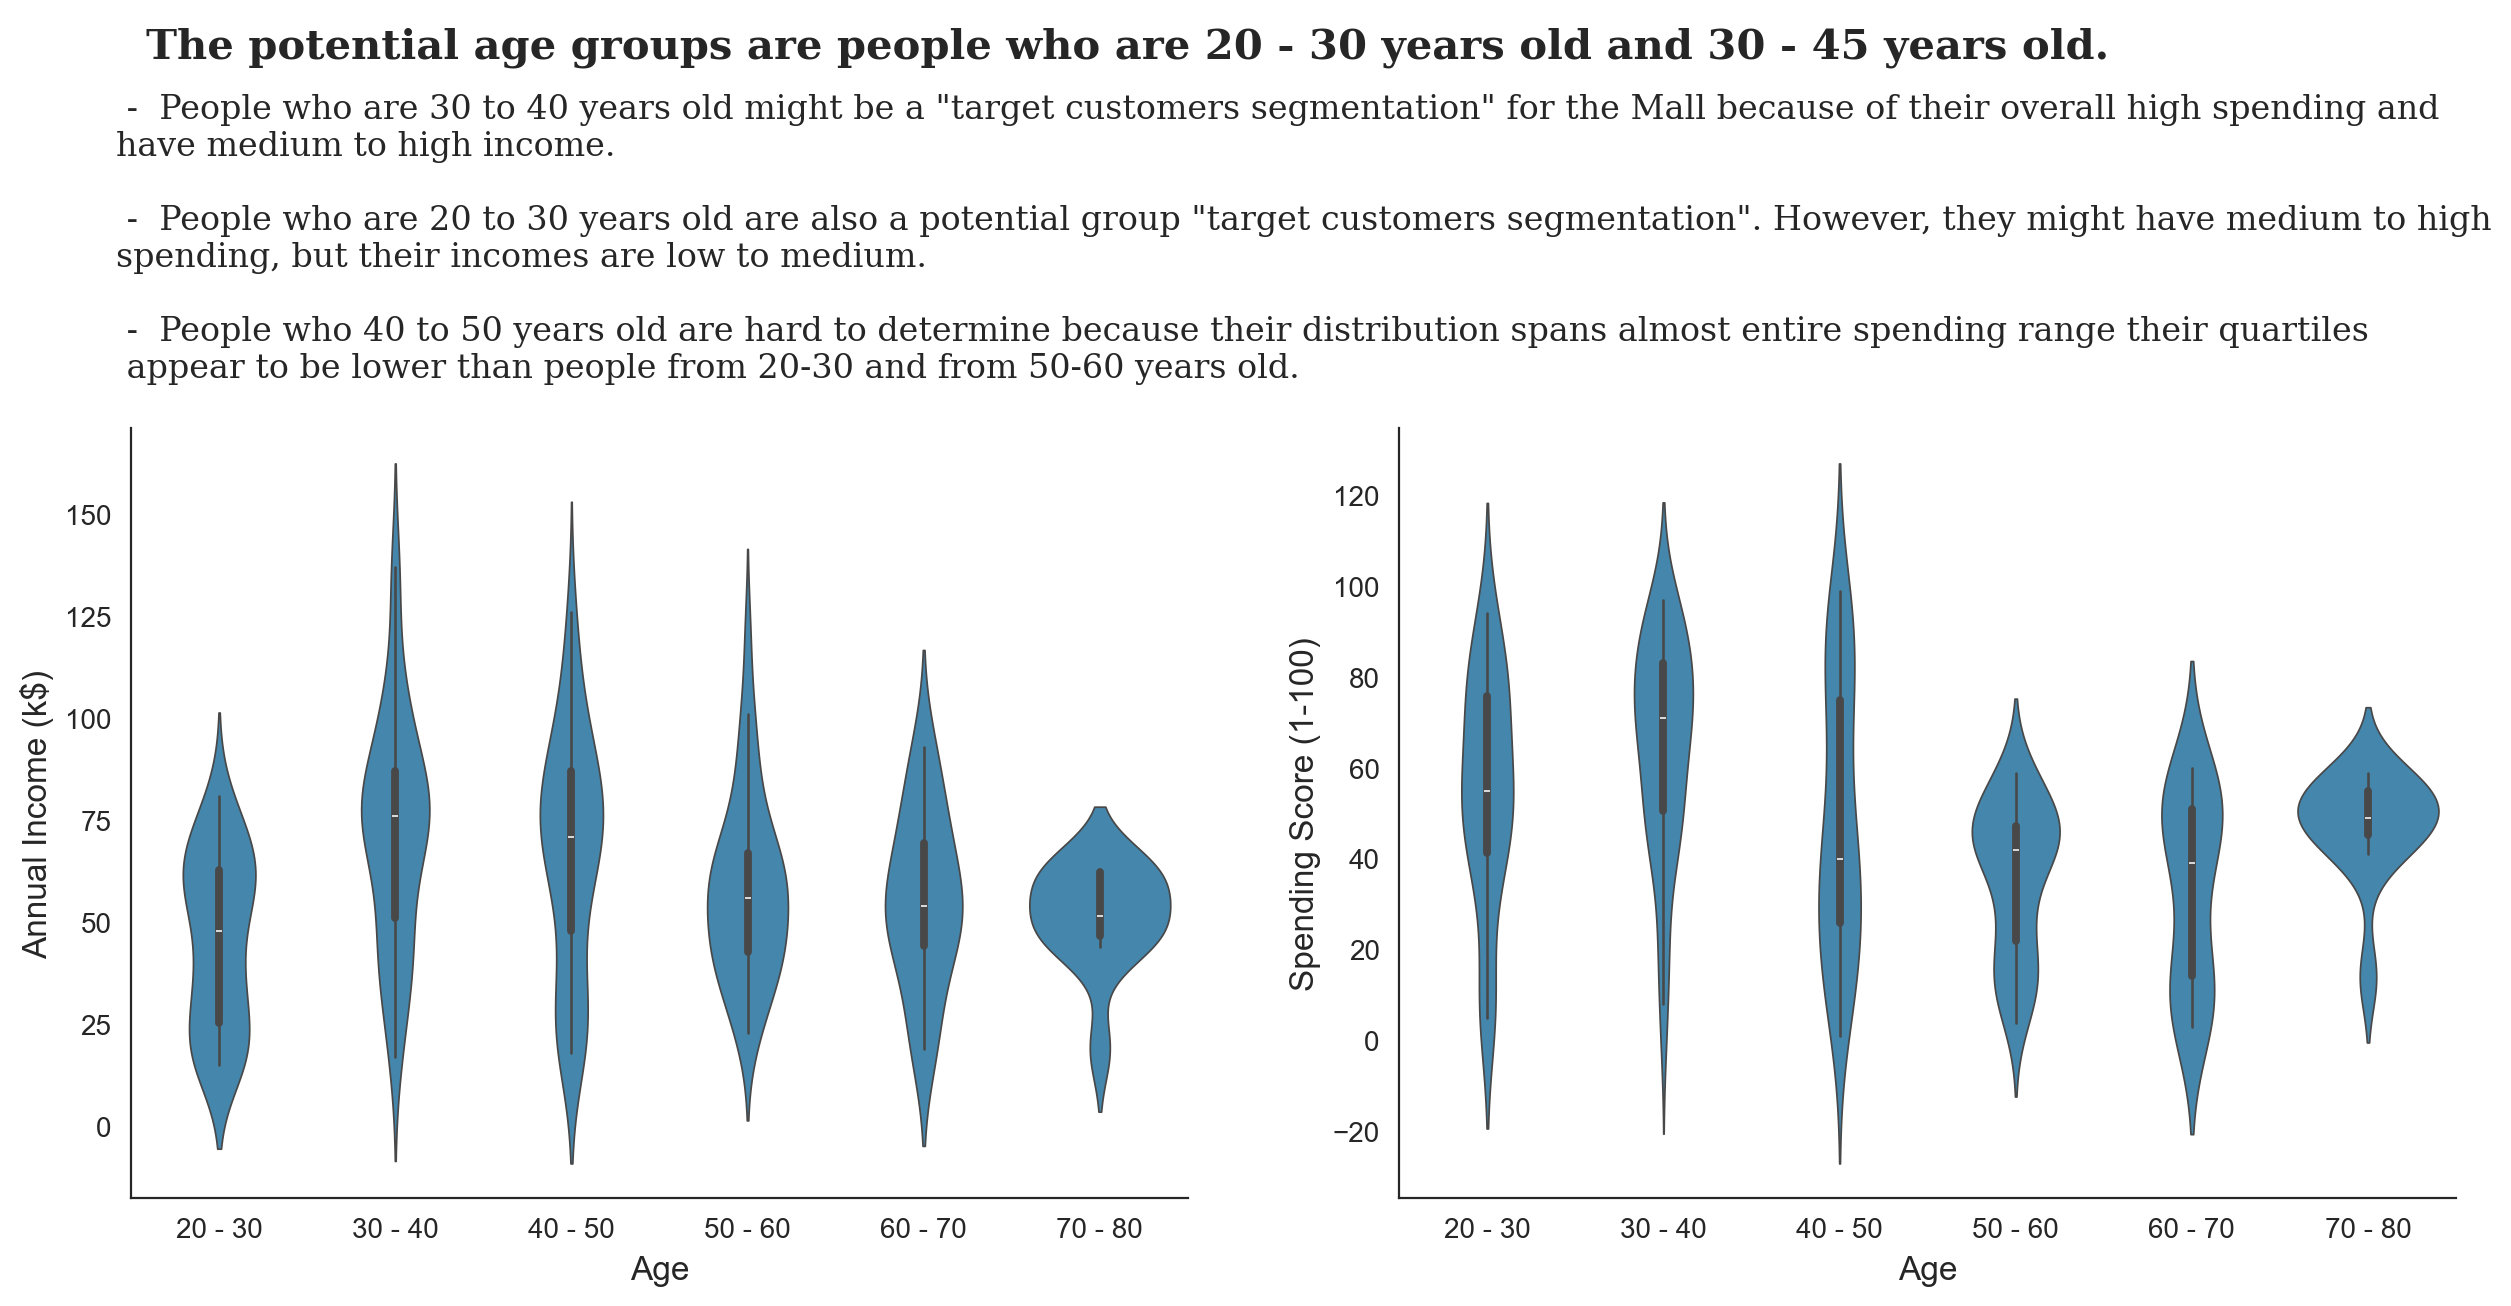

In [206]:
fig = plt.figure(figsize=(15,5), dpi=200)
index=1

fig.text(0.13, 1.25, 'The potential age groups are people who are 20 - 30 years old and 30 - 45 years old.', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.12, .82, '''

 -  People who are 30 to 40 years old might be a "target customers segmentation" for the Mall because of their overall high spending and
have medium to high income.

 -  People who are 20 to 30 years old are also a potential group "target customers segmentation". However, they might have medium to high
spending, but their incomes are low to medium. 

 -  People who 40 to 50 years old are hard to determine because their distribution spans almost entire spending range their quartiles 
 appear to be lower than people from 20-30 and from 50-60 years old.
 

''',  fontsize=12, fontweight='light', fontfamily='serif')

for i in ['Annual Income (k$)' , 'Spending Score (1-100)']:    
    fig.add_subplot(1, 2, index)
    sns.violinplot(x=cluster["Age"].round(-1), y=cluster[i], formatter=lambda x: f"{int(x)} - {int(x + 10)}")
    sns.despine()
    index += 1
plt.savefig("Clustering/images/age_violinplot", bbox_inches='tight', dpi=300)
plt.show()


## K-Means Cluster

Before usng K-Means clustering, the parameter n_clusters, random_state needs to be found so that the model will perform the best. 

 - n_clusters -- Evaluate inertia values across different numbers and visualize it with the Elbow in the Scree Plot to find the proportition of variance.
 - random_state -- check with n-clusters using Silhoutte and heatmap


### Standardlized all the feature variables

### Check n_clusters numbers with Elbow scree plot

In [19]:
cluster_df = cluster.drop(['Gender','age_range'], axis=1).reset_index()
scaler = StandardScaler()
scaled_cluster = scaler.fit_transform(cluster_df)

In [20]:
import copy
cluster_train = copy.deepcopy(df)
cluster_train=cluster_train.drop(columns=['CustomerID','Gender'], axis=1)
Scaled_traincluster = scaler.fit_transform(cluster_train)

In [21]:
def screeplot(data):
    """ Check the n_clusters with random_state=0
    Display clusters with inertia to choose best numbers
    """
    inertias = []
    cluster_range = list(range(2, 15))
    for cluster in cluster_range:
        clt = KMeans(n_clusters=cluster, random_state=0, n_init=30).fit(data)
        inertias.append(clt.inertia_)

    fig, ax = plt.subplots(figsize=(15,7), dpi=200)
    plt.plot(cluster_range,inertias, '-.', linewidth=5, marker='o', markersize=14, color='C2', alpha=0.8)

    
    # Graph title and subtitle
    fig.text(0.12, 0.93, "6 Clusters will be chosen for clustering Age, Spending, and Annual Income features",  
             fontfamily='serif',fontsize=15, fontweight='bold')
    fig.text(0.121, 0.89, "Clusters are chosen based on 2 factors: low inertia and resonable cluster's numbers",  
             fontfamily='serif',fontsize=12)
    
    # x,y titles
    plt.xlabel('Number of Clusters',fontsize=12, fontweight='bold') 
    plt.ylabel('Inertia',fontsize=12, fontweight='bold')
    plt.xticks(np.arange(0, 15, 1))
    ax.spines[['right', 'top']].set_visible(False)

    plt.grid(visible=True, axis="y")
    ax.axvline(x=6, ymin=0.1, ymax=0.8, ls='--', color='tab:gray', linewidth= 2)
    ax.tick_params(axis='x', labelcolor='black', length=4, direction='out')
    plt.savefig("Clustering/images/clustering_screeplot", bbox_inches='tight', dpi=300)
    plt.show()

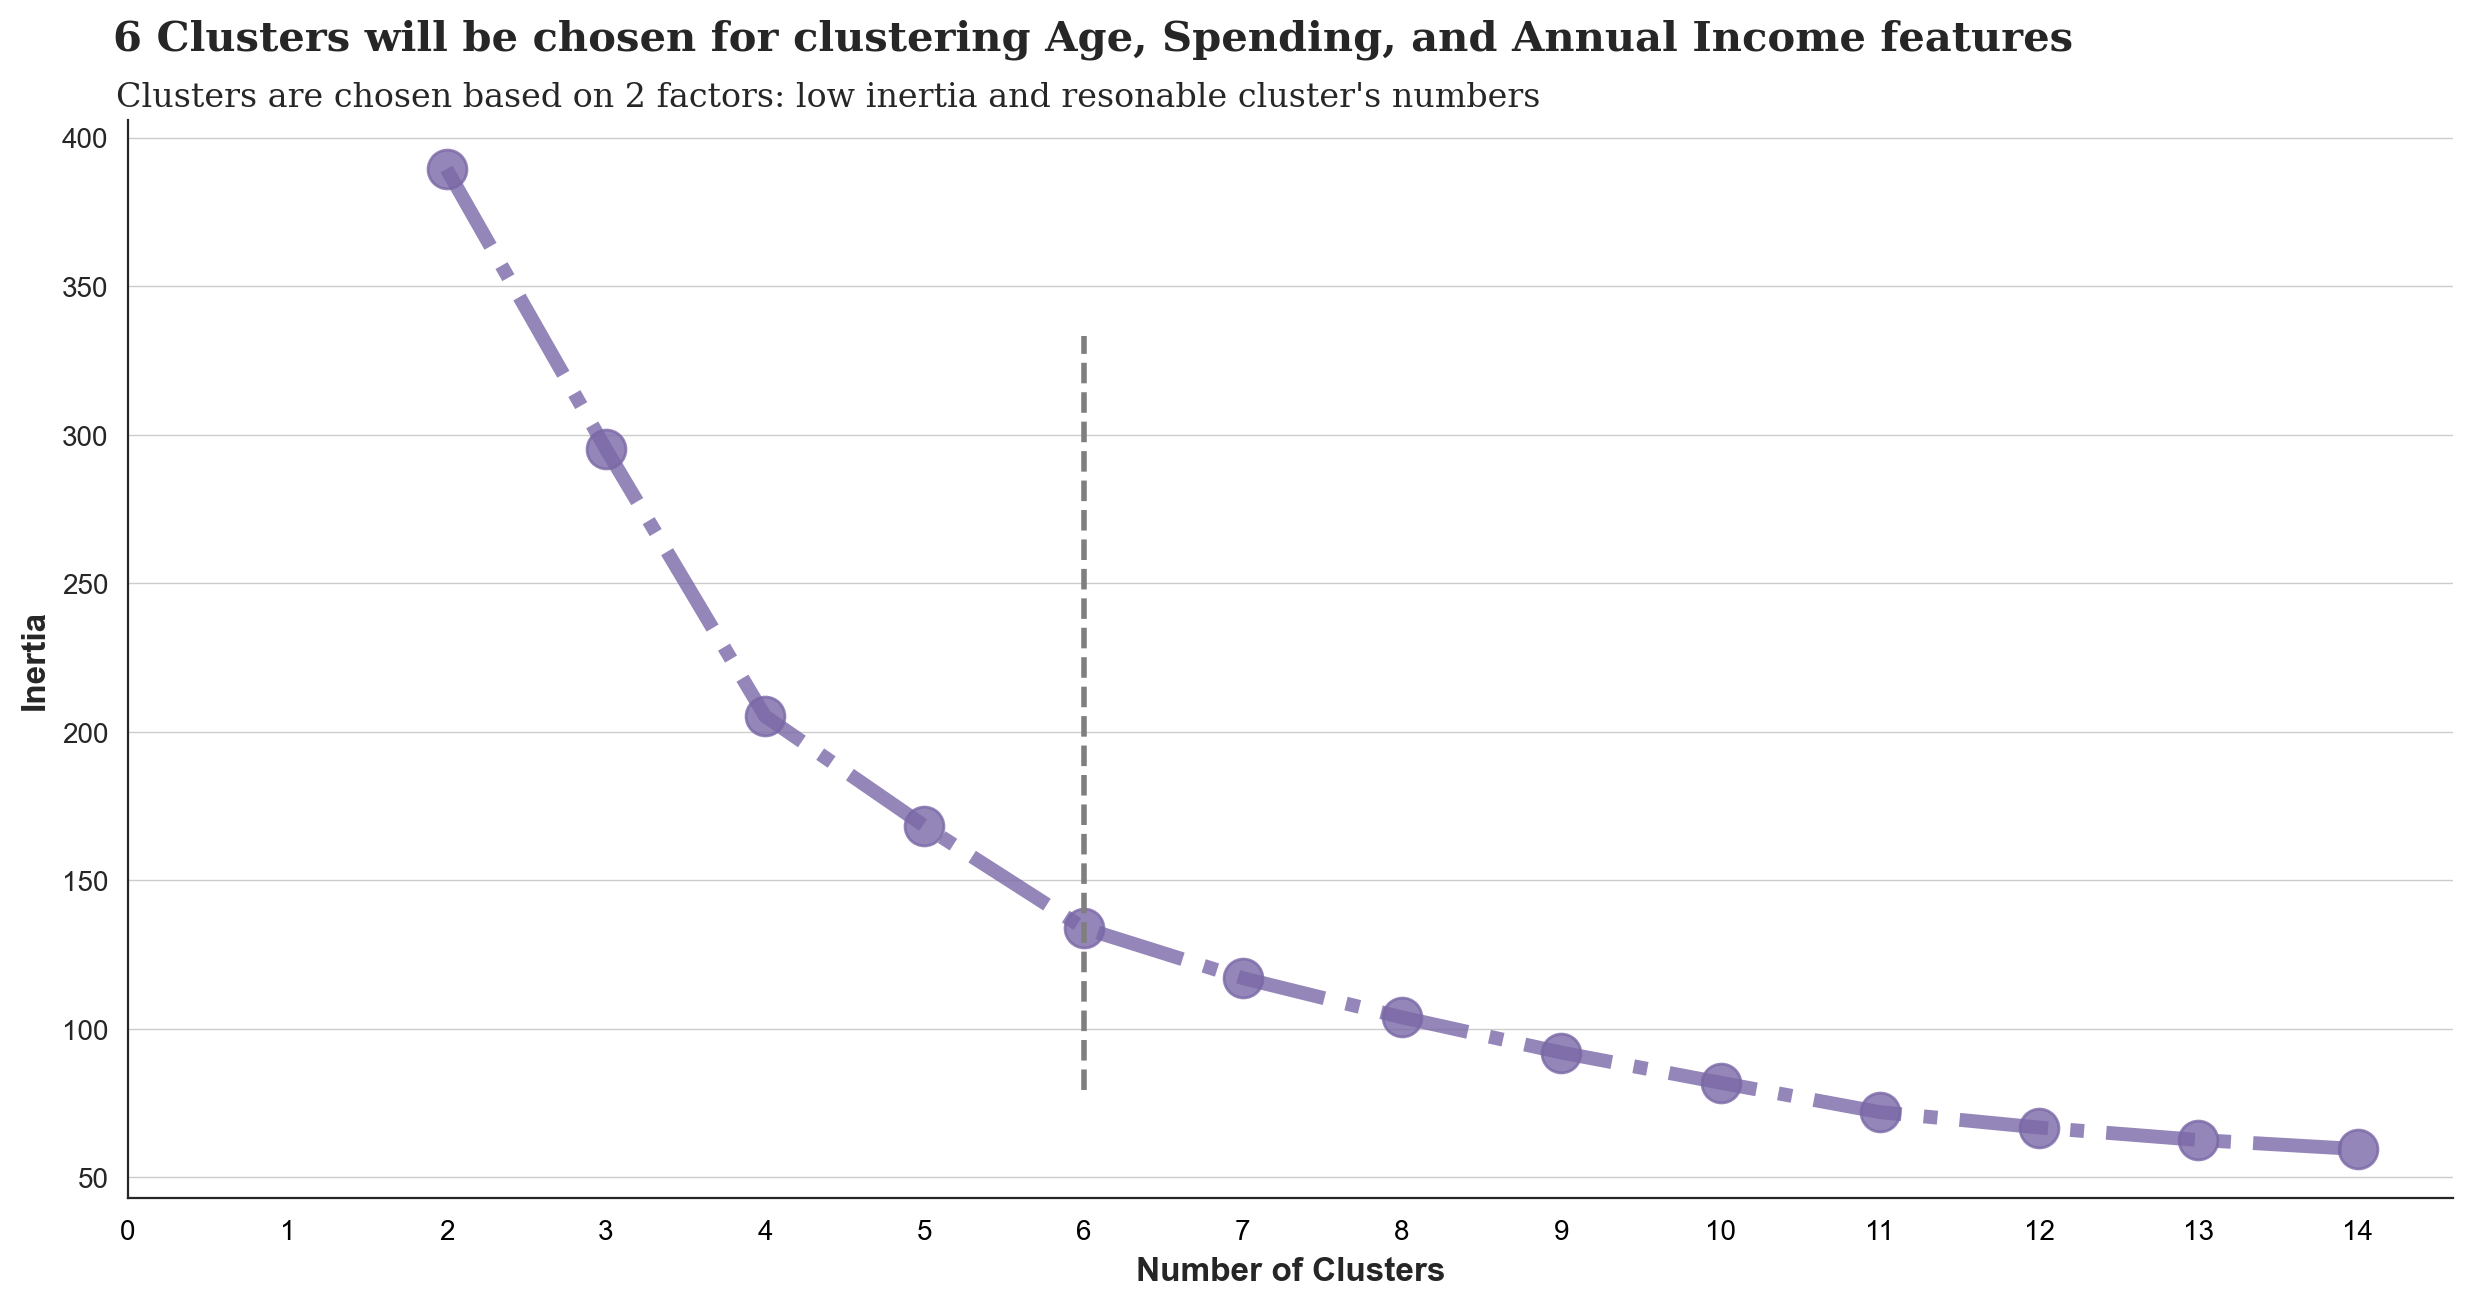

In [22]:
screeplot(Scaled_traincluster)
        

### Check random_state with different n_clusters numbers with Silhouette Analysis

In [23]:
def random_clusters_silhouette(data):
    """With each n_cluster
    Check every random_state in random_range
    Find the silhouette_score for that set
    Iterate the process with different n_cluster and every random
    Append cluster, random, silhouette_score to Results
    """
    
    n_clusters = range(2,15)
    random_range = range(0,30)
    results =[]

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    for cluster in n_clusters:
        for random in random_range:
            kmeans = KMeans(n_clusters=cluster, random_state=random, n_init=30)
            kmeans_labels = kmeans.fit_predict(data)
            silhouette_avg = silhouette_score(data, kmeans_labels)
            results.append([cluster, random, silhouette_avg])
    return results
            

In [24]:
random_and_Silhou_results = pd.DataFrame(data=random_clusters_silhouette(Scaled_traincluster), 
                               columns=["Number of clusters","Random generator seed","The Silhouette score"])
pivot_sil = pd.pivot(random_and_Silhou_results, 
                           index="Number of clusters", 
                           columns="Random generator seed",
                           values="The Silhouette score")

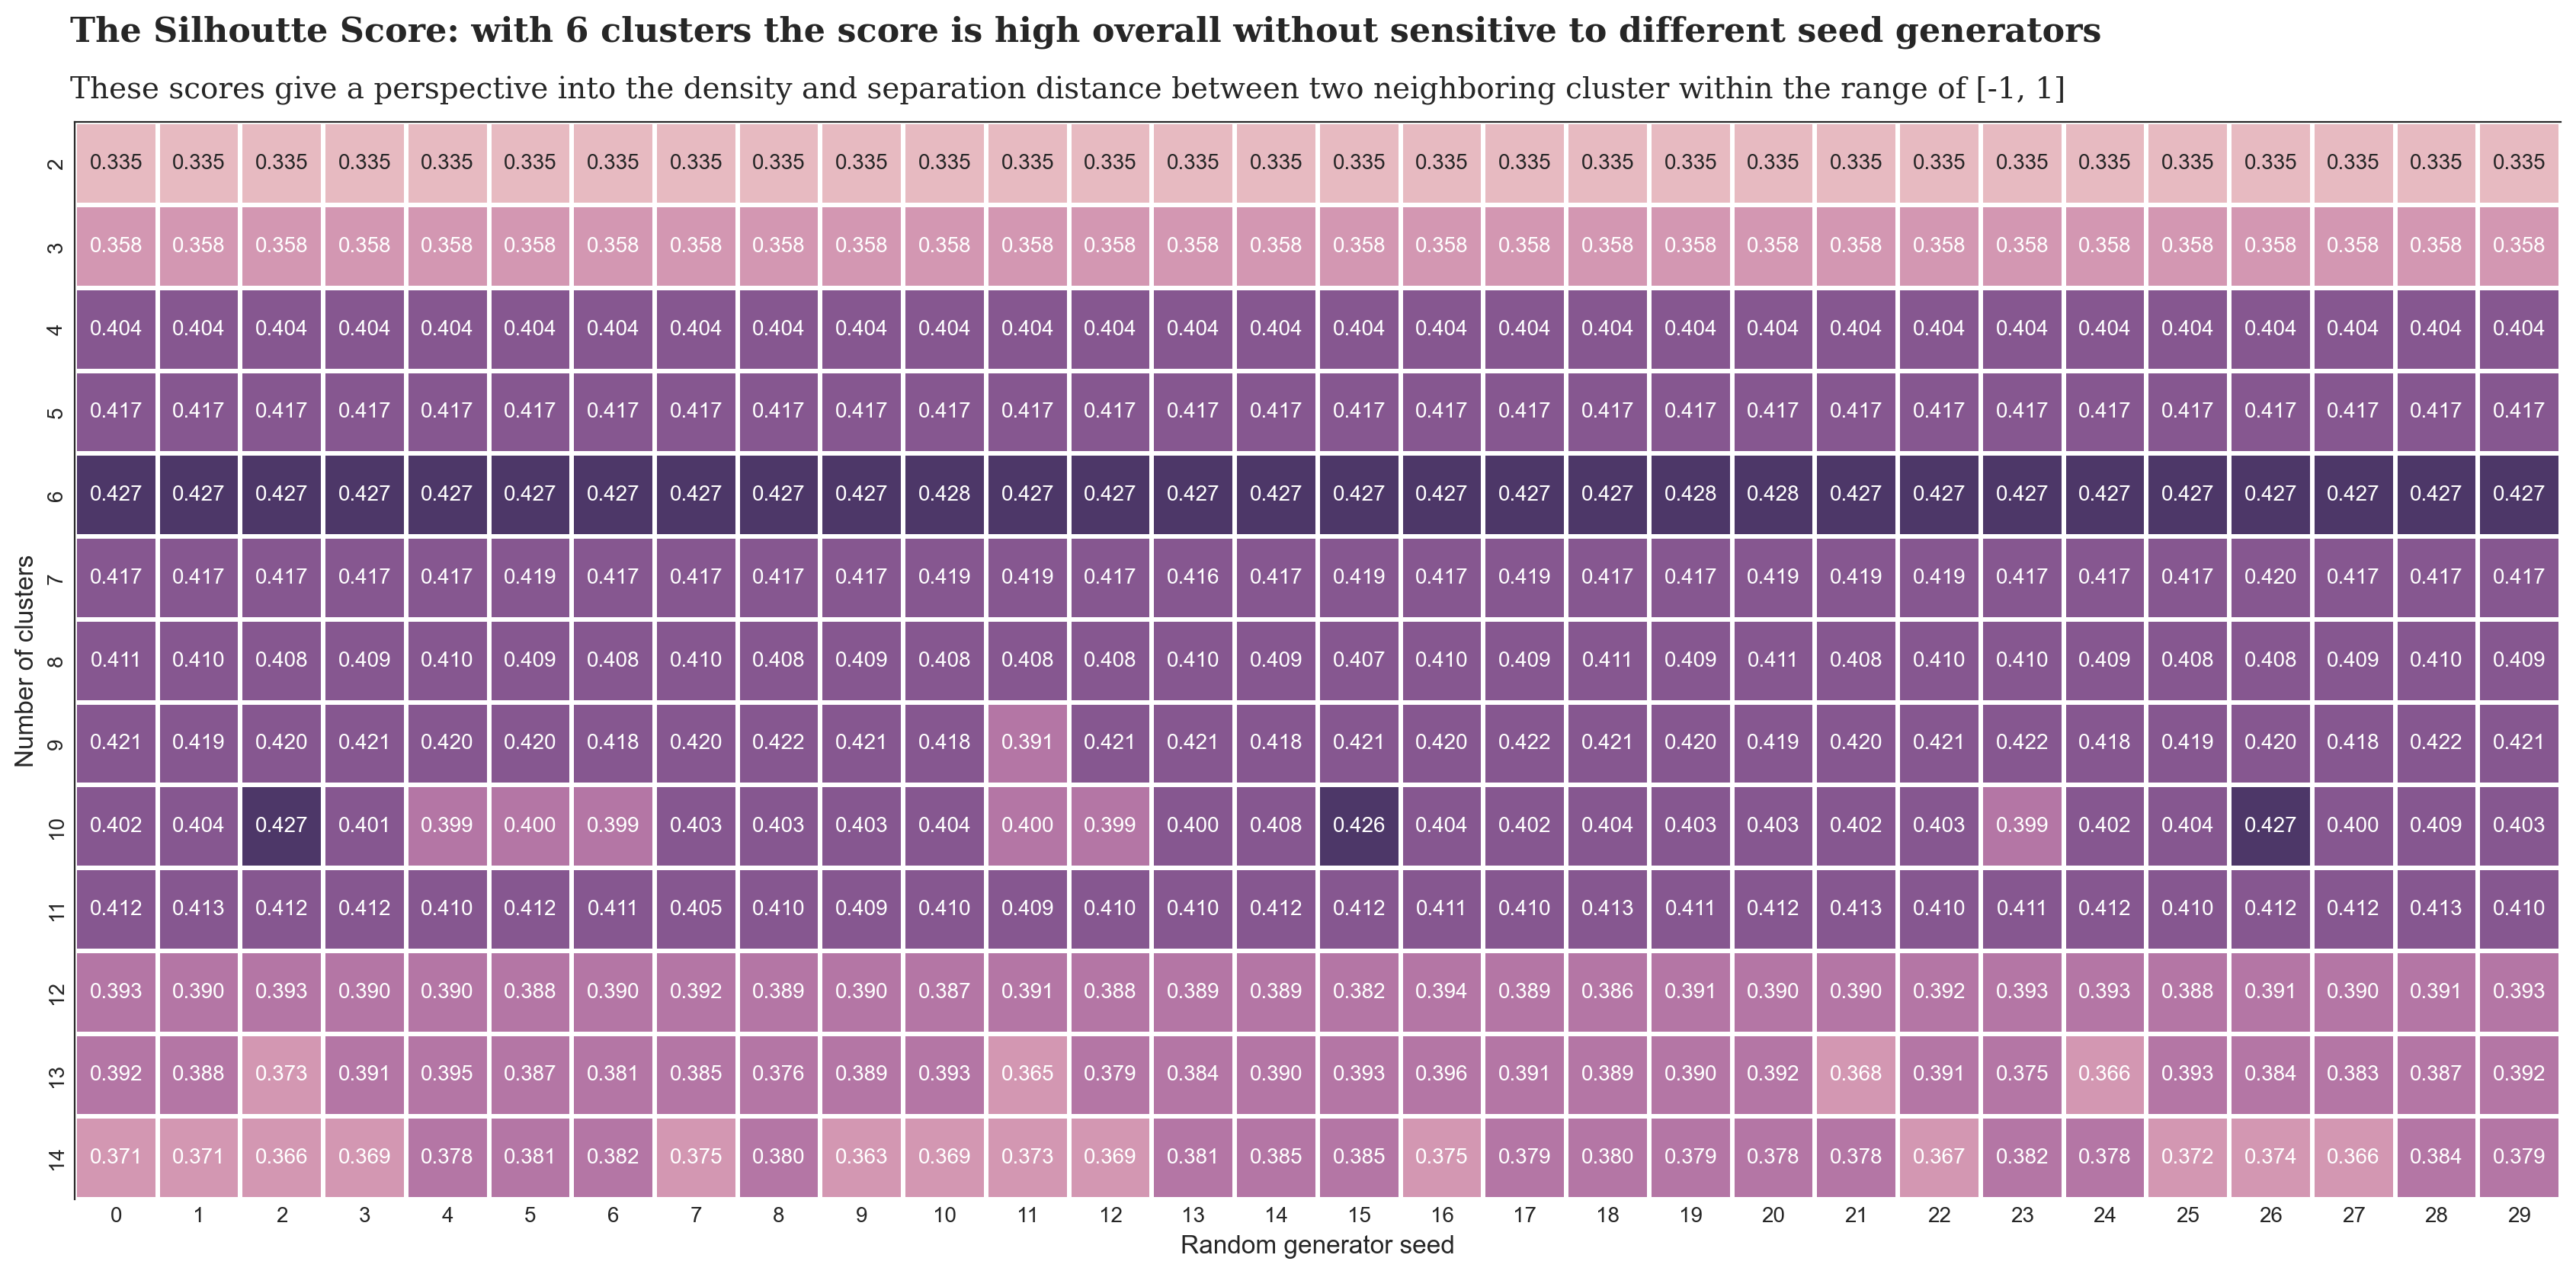

In [25]:
fig, ax= plt.subplots(figsize=(17, 8), dpi=200)


pl=sns.heatmap(pivot_sil, annot=True, vmin=.3, vmax=.45, square=True,
            linewidths=2, fmt= '.3f', cbar=False, cmap=sns.cubehelix_palette(gamma=.7))

fig.text(0.03, 1.04, "The Silhoutte Score: with 6 clusters the score is high overall without sensitive to different seed generators",  
             fontfamily='serif',fontsize=16, fontweight='extra bold', va='top')
fig.text(0.03, 0.99, "These scores give a perspective into the density and separation distance between two neighboring cluster within the range of [-1, 1]",  
             fontfamily='serif',fontsize=14, va='top')
ax.spines[['top','left']].set_visible(True)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.savefig("Clustering/images/silhoutte_scatterplot", bbox_inches='tight', dpi=300)
plt.show()

### Silhouette Plot
So far, we checked the Silhouette coefficients to evaluate the n_clusters and random_state numbers. We confirmed that n_clusters=6 is the optimal value, but the random_state numbers have many numbers with the same Silhouette score. 

Therefore, we will validate our choice by plotting Silhouette score against kmeans.labels_. We will examine the plot with those conditions:

    - The presence of clusters are more or less of similar thickness and the size of the silhouette plots aren't in wide fluctuations.
    - Cluster scores should be higher than the average silhouette score

In [26]:
import matplotlib.cm as cm
def cluster_silhouette_plot(data, min_cluster, max_cluster):
    cl_range = list(range(min_cluster, max_cluster+1))
    
    for n_clusters in cl_range:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2,  dpi=150)
        fig.set_size_inches(18, 7)
     
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        kmeans = KMeans(n_clusters=n_clusters, random_state=10, n_init=30)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        
        print("For n_clusters =",n_clusters,"The average silhouette_score is :",silhouette_avg)

        sample_sil_values = silhouette_samples(data, cluster_labels)
        y_lower=10
       
        for i  in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
            ith_cluster_silhouette_values = sample_sil_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
        
            ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                facecolor=color, edgecolor=color, alpha=0.8)
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10 #y_lower for 2nd plot
            
        
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The Silhouette Coefficient is %0.3f" % silhouette_avg)
        ax1.set_ylabel("Cluster label")
    
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2.5)
    
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
       
        fig.text(0.13, 0.98, "Silhouette analysis for KMeans clustering on Mall Data with n_clusters = %d" % n_clusters,
             fontfamily='serif',fontsize=16, fontweight='extra bold', va='top')

        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker=".", s=250, lw=0, alpha=0.9, c=colors, edgecolor="k")

        # Labeling the clusters
        centers = kmeans.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0],centers[:, 1], marker="o",c="white",alpha=1, s=200, edgecolor="k")    
        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=70, edgecolor="k")
    
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")
        fig=plt.gcf()
        fig.savefig("Clustering/images/compare_silhouette_plot{}".format(n_clusters), bbox_inches='tight', dpi=300)
    plt.show()      


For n_clusters = 5 The average silhouette_score is : 0.41664341513732767
For n_clusters = 6 The average silhouette_score is : 0.42841677628925934
For n_clusters = 7 The average silhouette_score is : 0.4192190521496921


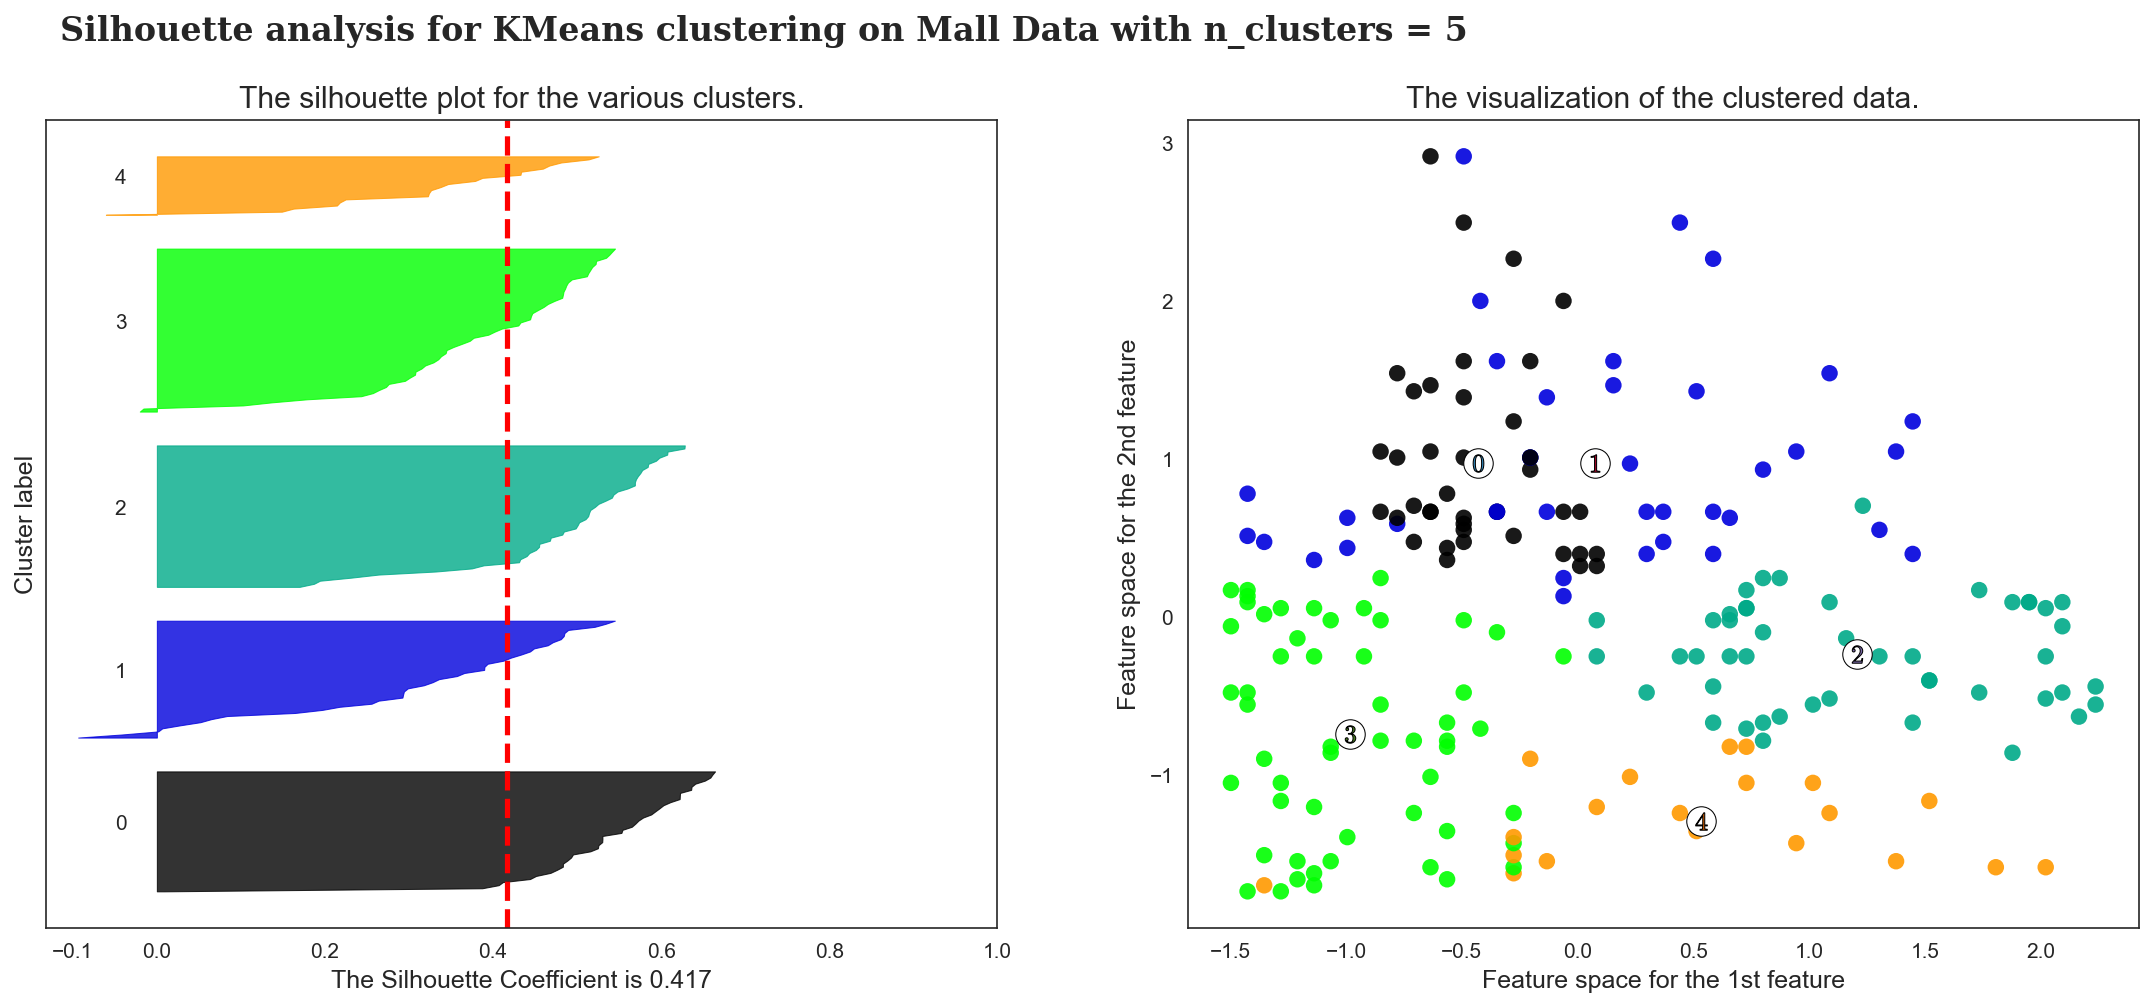

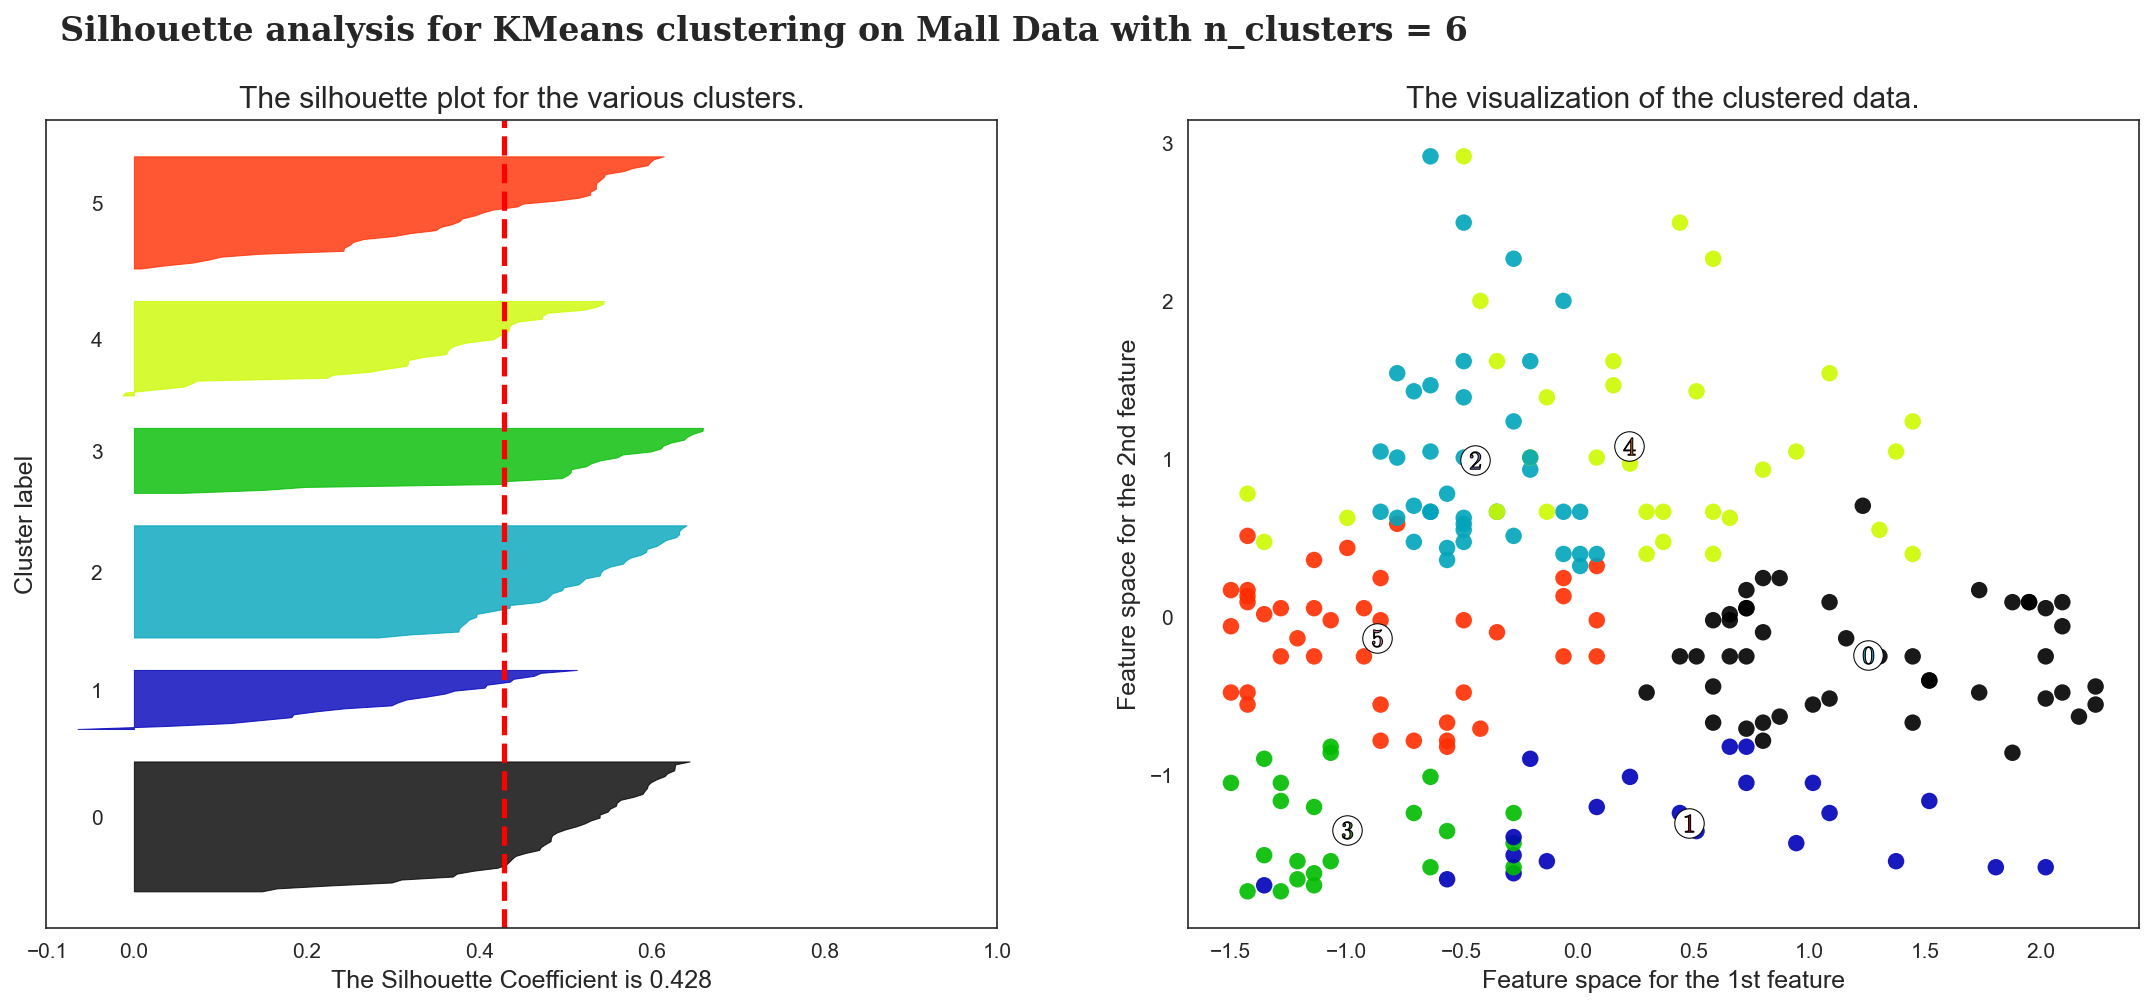

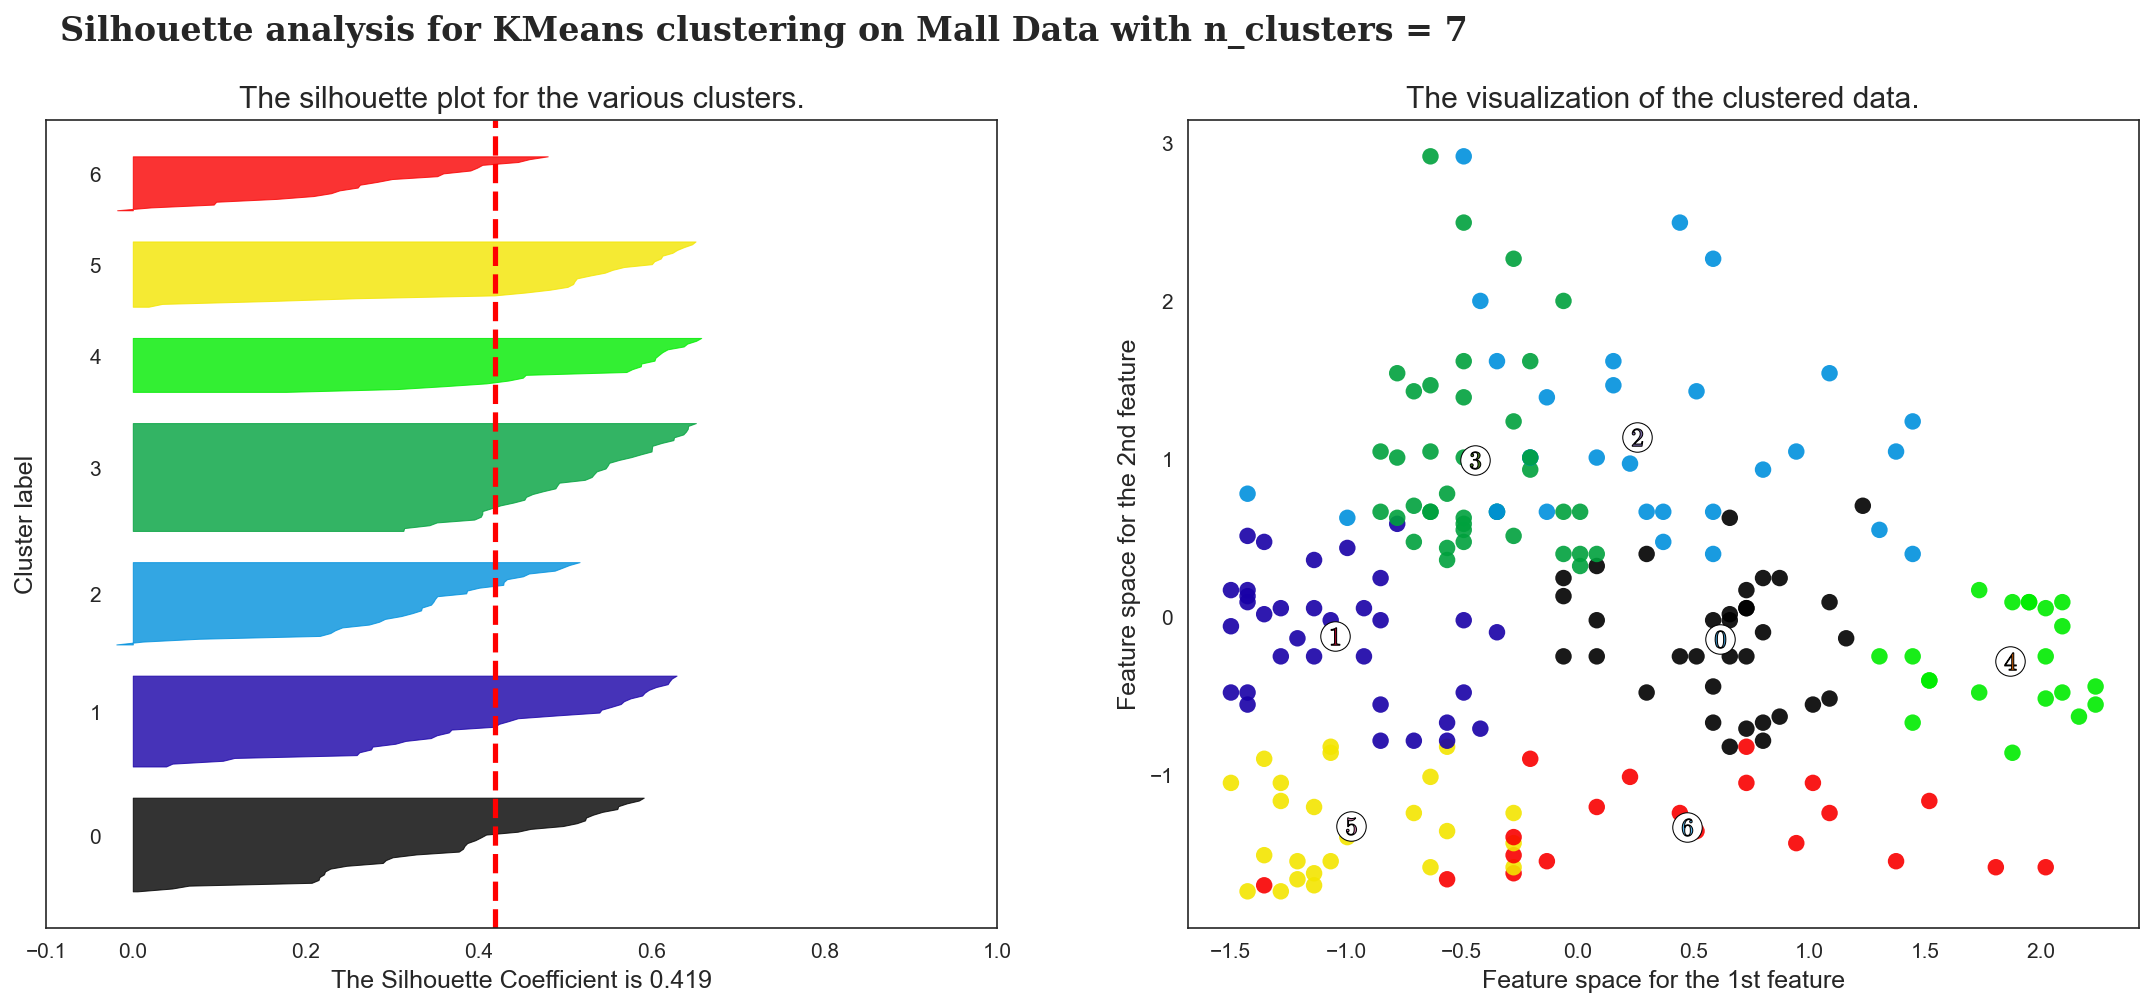

In [27]:
cluster_silhouette_plot(Scaled_traincluster, 5, 7)

#### When evaluating the sihouette plot, we want to achieve:

- The presence of clusters are more or less of similar thickness and the size of the silhouette plots aren't in wide fluctuations.
- Cluster scores should be higher than the average silhouette score.

  
  --> From the 3 demo plots, we achieve these conditions with n_clusters=6 and random_state=10, n_init=30

# Clusters Analysis and Insights

In [28]:
kmeans_cluster = KMeans(n_clusters=6, random_state=10, n_init=30).fit(Scaled_traincluster)
clt_labels = pd.Series(kmeans_cluster.labels_)
cluster_train=cluster_train.assign(Clusters=clt_labels)
grouped = cluster_train.groupby('Clusters').mean().round(1).reset_index()
grouped

Clusters   Age  Annual Income (k$)  Spending Score (1-100)
0         0  56.3                54.3                    49.1
1         1  45.5                26.3                    19.4
2         2  32.7                86.5                    82.1
3         3  25.0                25.3                    77.6
4         4  41.9                88.9                    17.0
5         5  26.8                57.1                    48.1

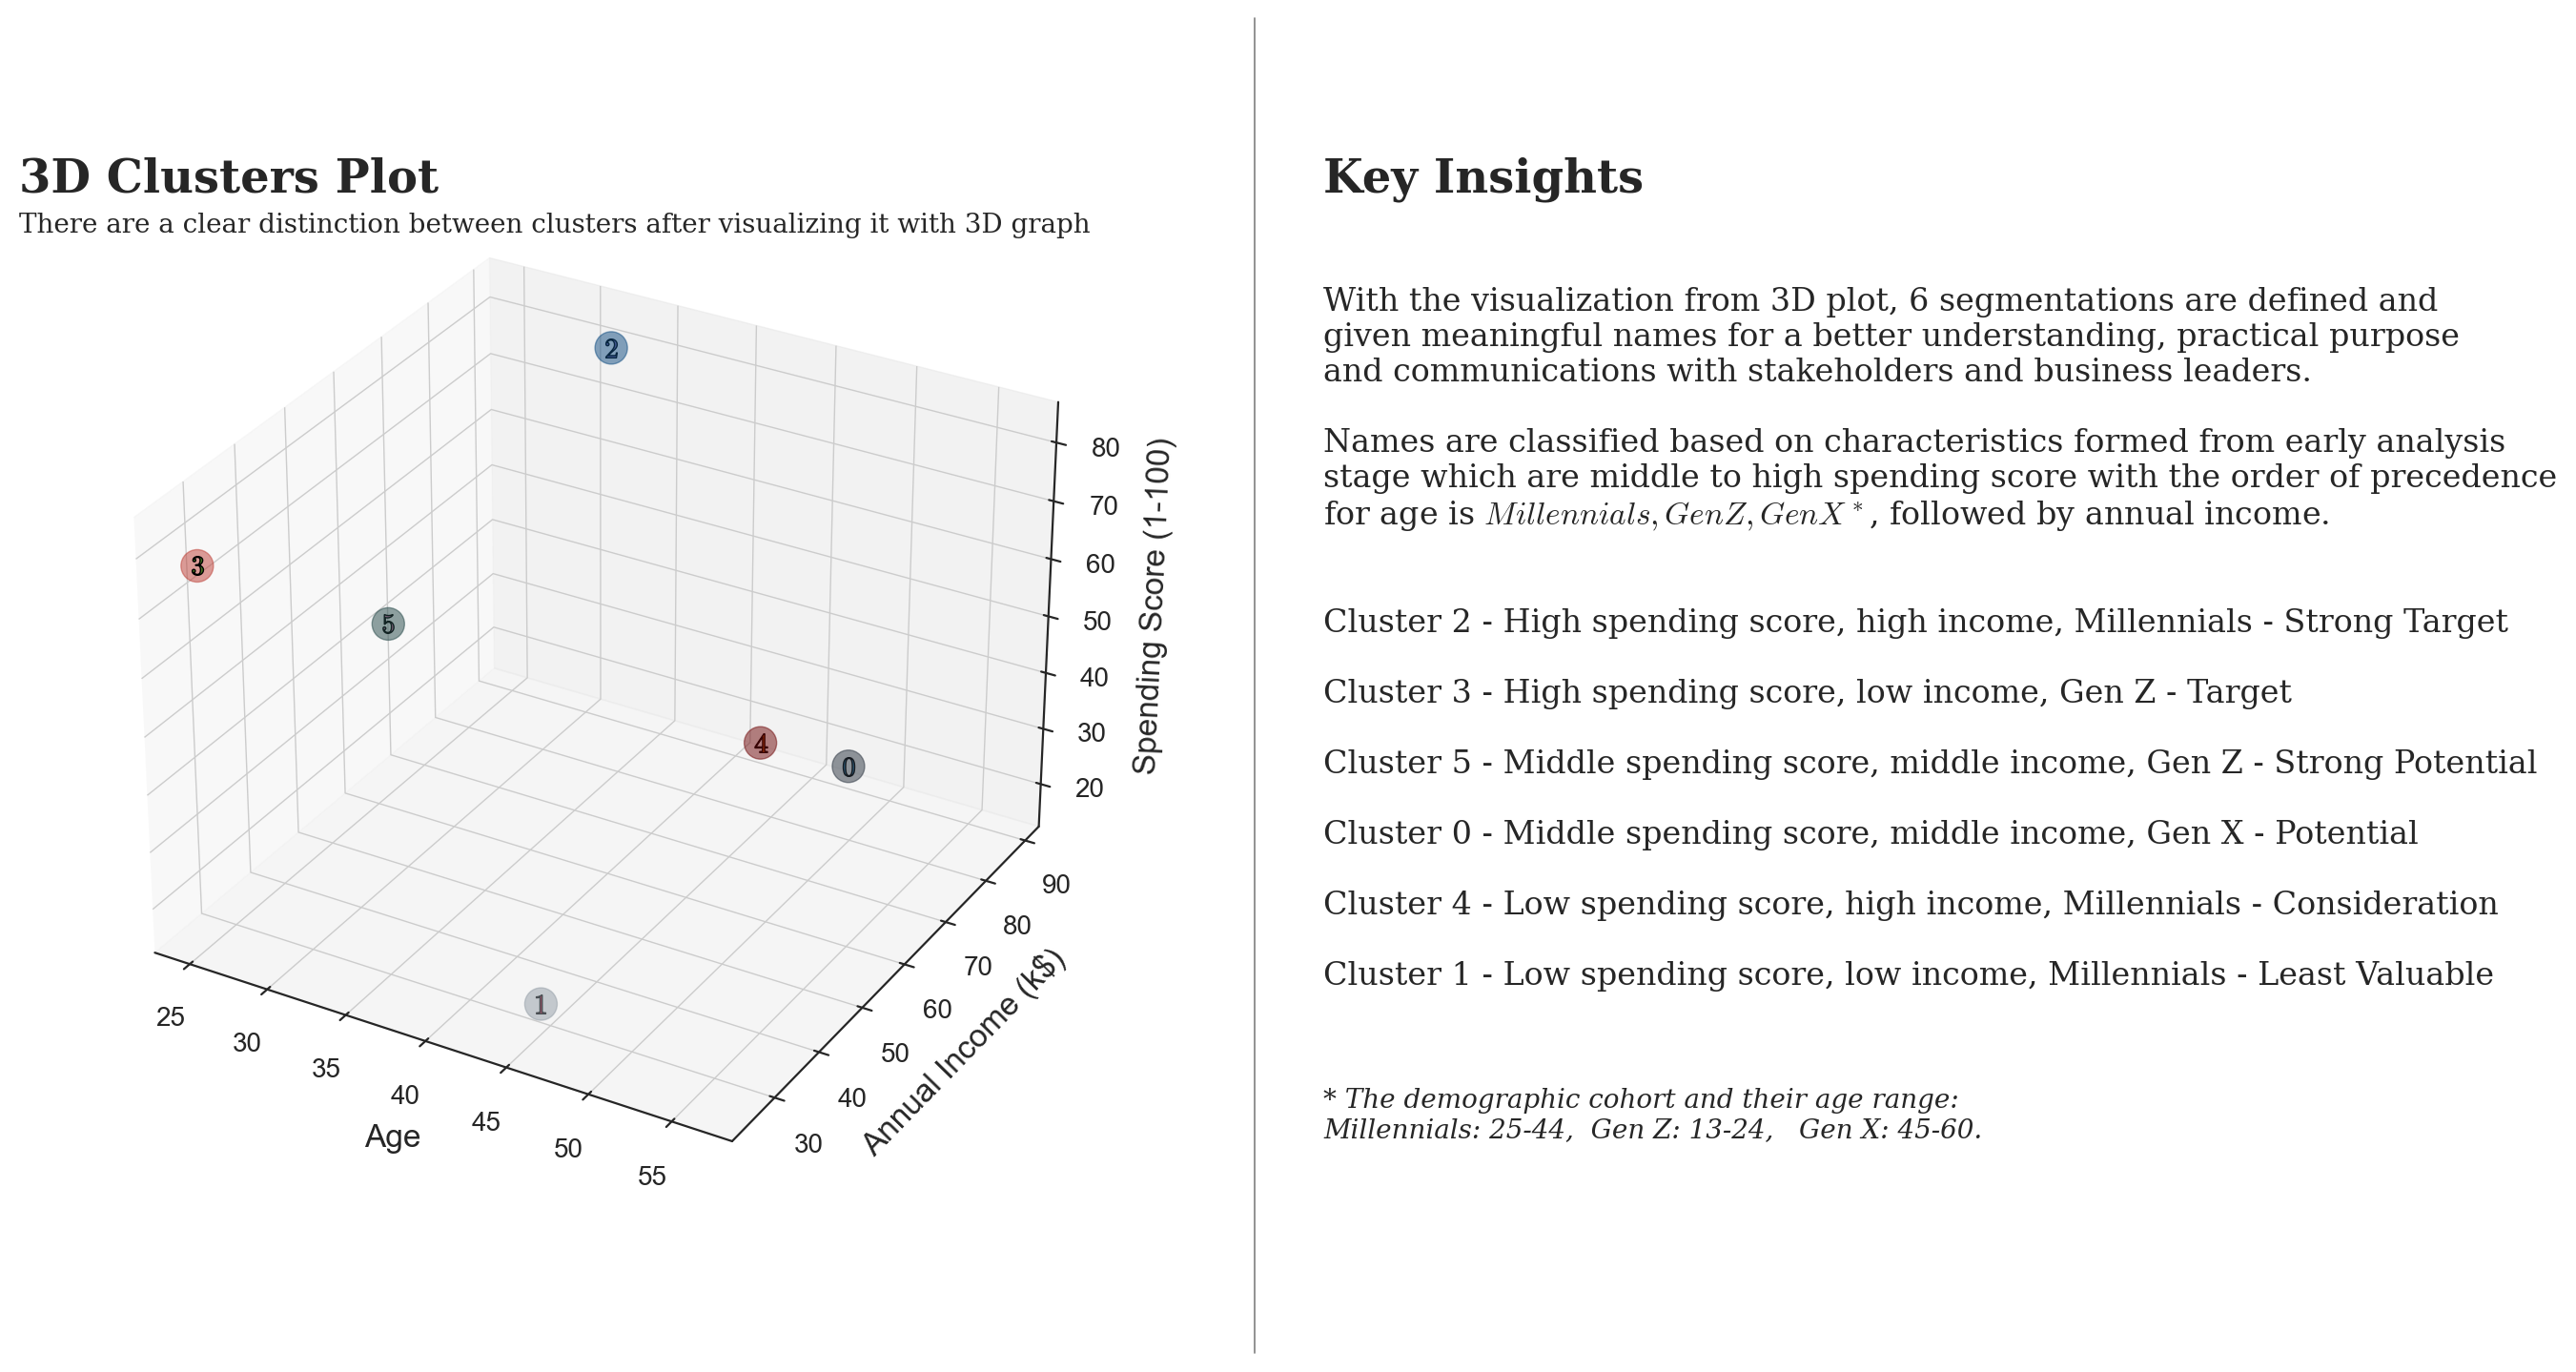

In [139]:
fig= plt.figure()
fig.set_size_inches(12, 7)
ax = fig.add_subplot(111, projection='3d')
colors=['#2a333f','#939da6','#0f4c81','#be3e35','#70090a','#244747']

ax.scatter(xs="Age",ys="Annual Income (k$)",zs="Spending Score (1-100)", data=grouped,
               color=['#2a333f','#939da6','#0f4c81','#be3e35','#70090a','#244747'],alpha=0.5,s=150)


for i in range(6):
    ax.scatter(grouped["Age"][i],grouped["Annual Income (k$)"][i],grouped["Spending Score (1-100)"][i],
               marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    ax.set_zlabel("Spending Score (1-100)")
    ax.set_ylabel("Annual Income (k$)")
    ax.set_xlabel("Age")

fig.text(0.15, .87, '3D Clusters Plot', fontsize='xx-large', fontweight='extra bold', fontfamily='serif')
fig.text(0.15, .84, 'There are a clear distinction between clusters after visualizing it with 3D graph'
         , fontsize='medium', fontweight='light', fontfamily='serif')
fig.text(.72, 0.87, 'Key Insights', fontsize='xx-large', fontweight='bold', fontfamily='serif', ha='left')

fig.text(.72, 0.25, '''With the visualization from 3D plot, 6 segmentations are defined and 
given meaningful names for a better understanding, practical purpose
and communications with stakeholders and business leaders.

Names are classified based on characteristics formed from early analysis 
stage which are middle to high spending score with the order of precedence
for age is $Millennials, Gen Z, Gen X^*$, followed by annual income.


Cluster 2 - High spending score, high income, Millennials - Strong Target

Cluster 3 - High spending score, low income, Gen Z - Target

Cluster 5 - Middle spending score, middle income, Gen Z - Strong Potential

Cluster 0 - Middle spending score, middle income, Gen X - Potential

Cluster 4 - Low spending score, high income, Millennials - Consideration

Cluster 1 - Low spending score, low income, Millennials - Least Valuable
''', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(.72, 0.14, '''
* The demographic cohort and their age range: 
Millennials: 25-44,  Gen Z: 13-24,   Gen X: 45-60.
''', fontsize=10, style='italic', fontweight='light', fontfamily='serif')

fig.subplots_adjust(left=0.1,right=0.7)
import matplotlib.lines as lines
l1 = lines.Line2D([0.69, 0.69], [0, 1], transform=fig.transFigure, figure=fig,color='tab:gray',lw=0.6)
fig.lines.extend([l1])
plt.savefig("Clustering/images/3D_plot", bbox_inches='tight', dpi=300)
plt.show()

In [30]:
# Assign names to our clusters
clt_explore=copy.deepcopy(cluster_train)
clt_explore['Clusters_Labels'] = clt_explore['Clusters'].apply(lambda x: 'Strong Target' if x == 2 else
                                                              'Target' if x == 3 else
                                                              'Strong Potential' if x== 5 else
                                                              'Potential' if x== 0 else
                                                              'Consideration' if x== 4 else 'Least Valuable')
gender=df[['Gender']]
clt_explore = clt_explore.assign(Gender=gender)

## Clusters in Multivariable Analysis

### How clusters vary in different genders 

In [31]:
# Order for plotting categorical vars
clus_ord = ['0','1','2','3','4','5']
clus_label_order = ['Strong Target','Target', 'Strong Potential','Potential','Consideration', 'Least Valuable']

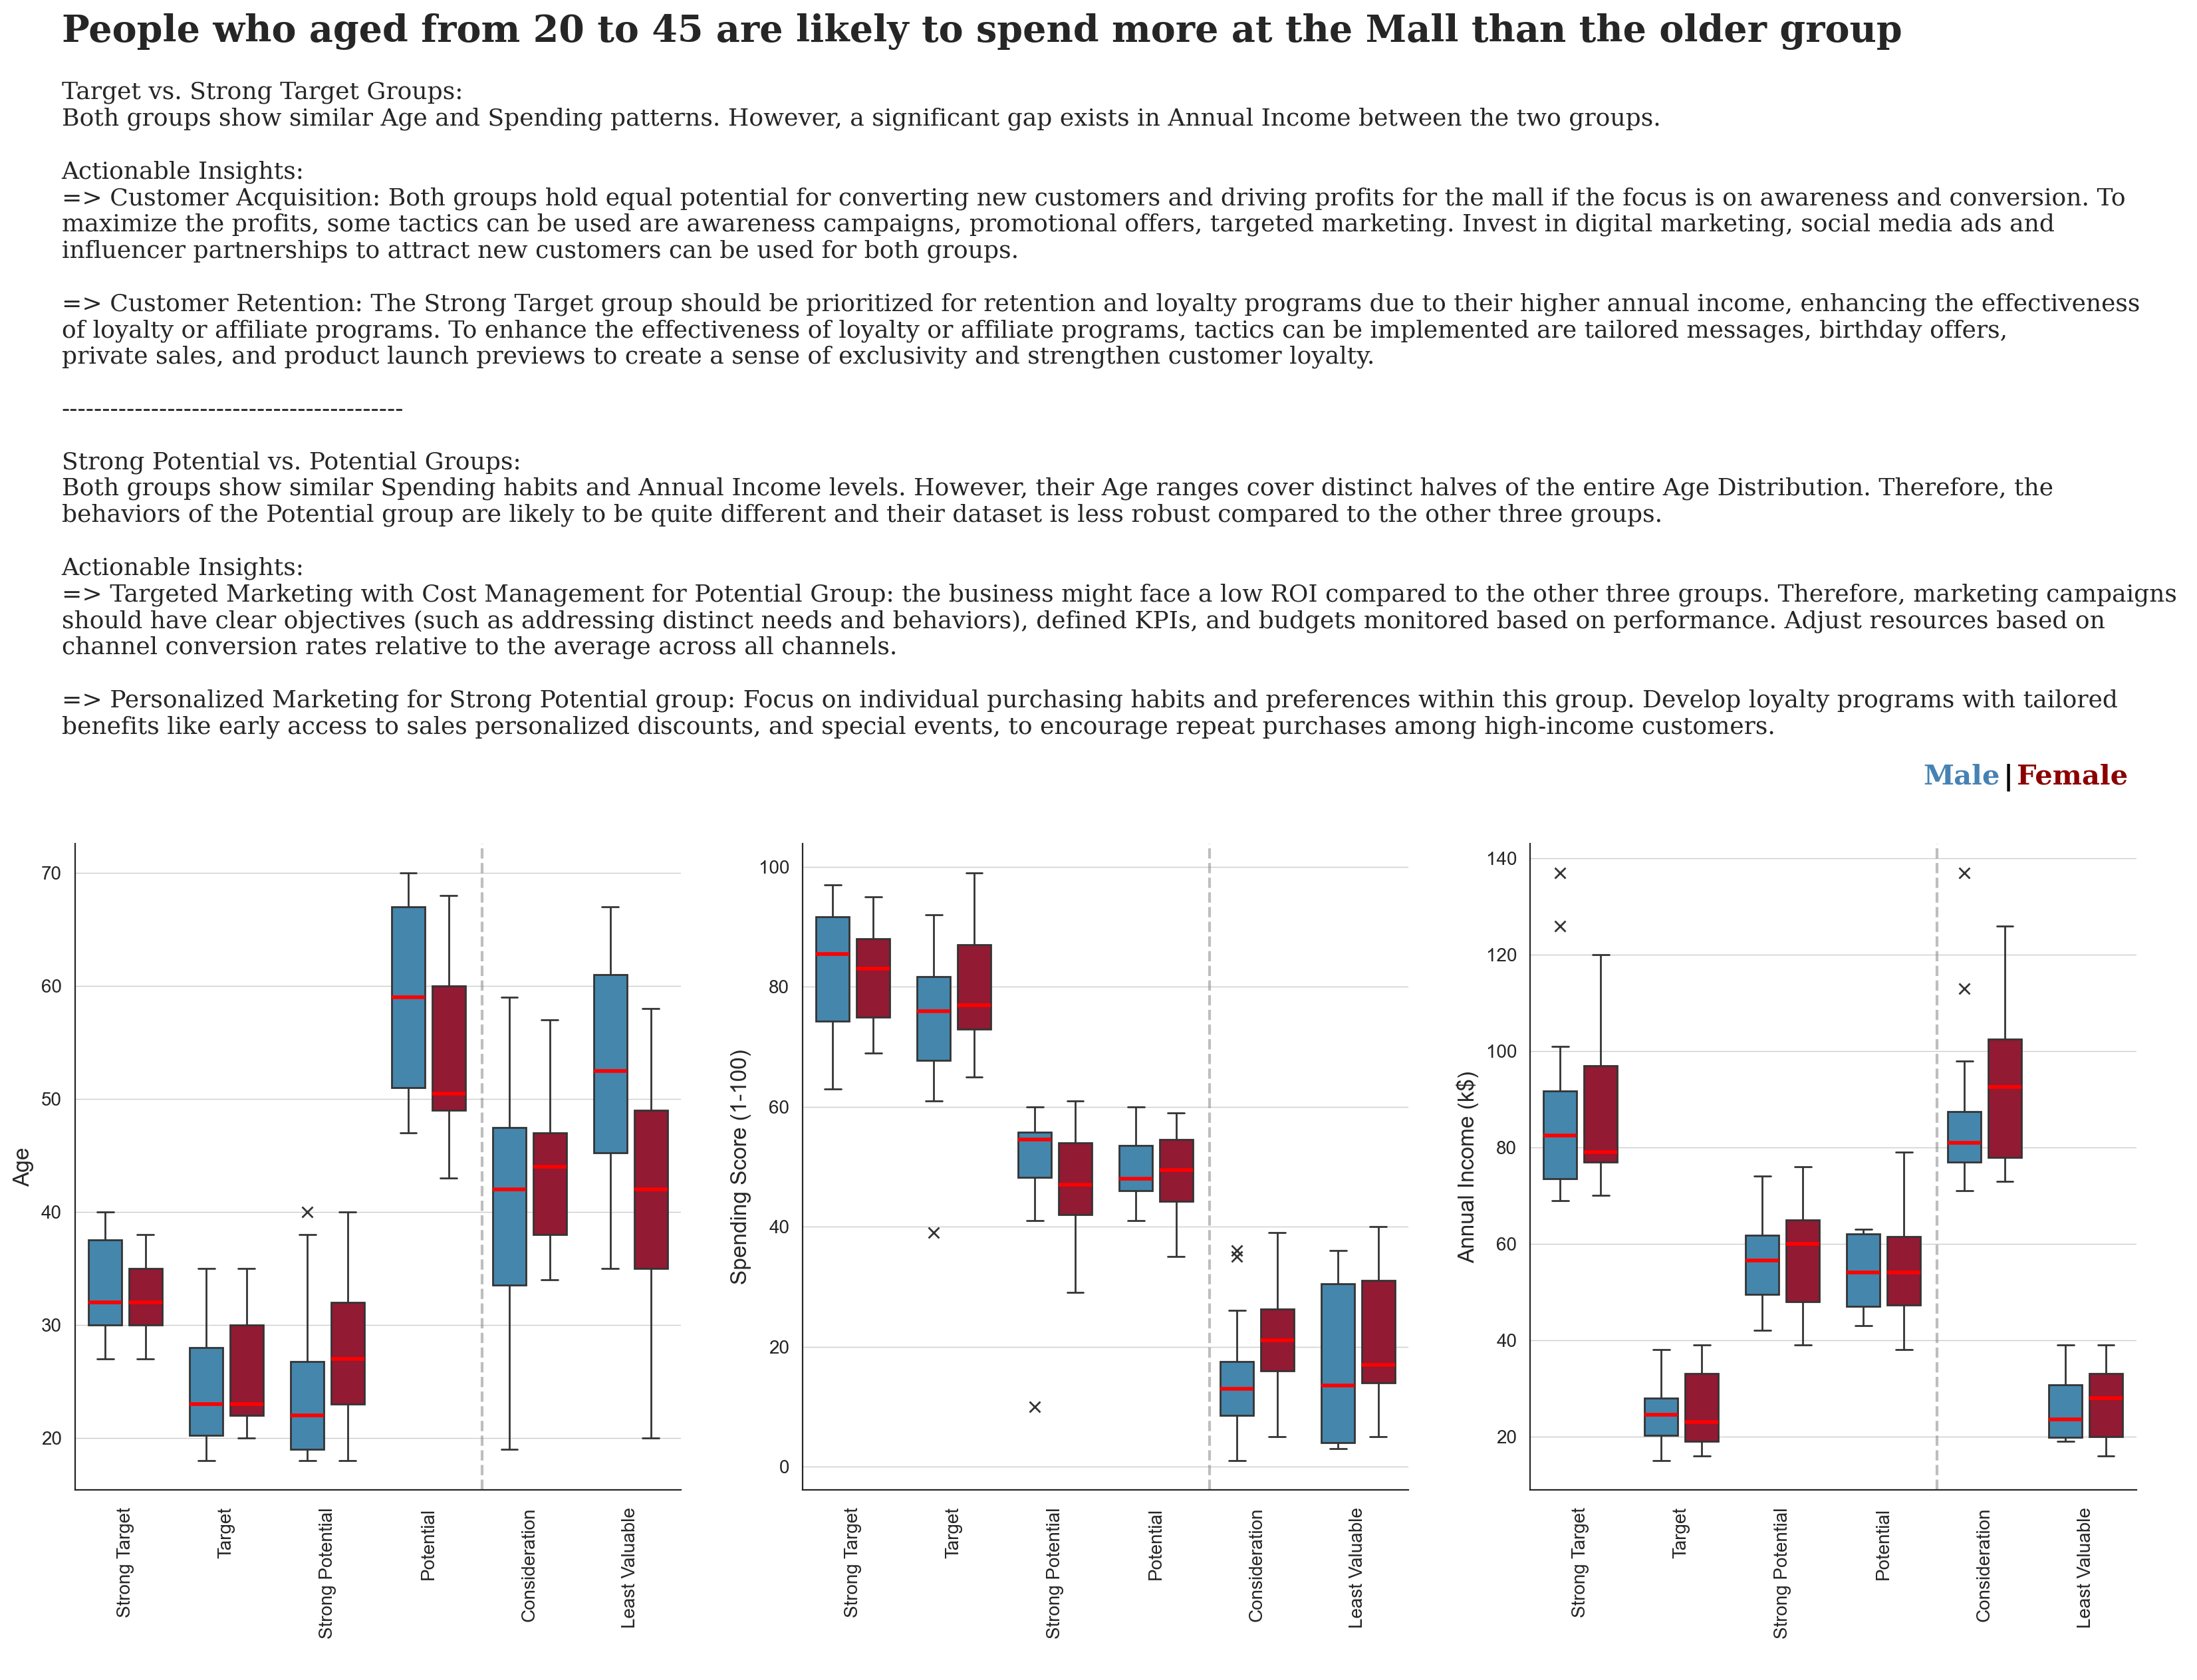

In [111]:
fig = plt.figure(figsize=(20, 9), dpi=200)
index = 1
fig.text(0.12, 1.32, 'People who aged from 20 to 45 are likely to spend more at the Mall than the older group', fontsize=20, fontweight='bold', fontfamily='serif')
fig.text(0.12, .72, '''
Target vs. Strong Target Groups:
Both groups show similar Age and Spending patterns. However, a significant gap exists in Annual Income between the two groups.

Actionable Insights:
=> Customer Acquisition: Both groups hold equal potential for converting new customers and driving profits for the mall if the focus is on awareness and conversion. To 
maximize the profits, some tactics can be used are awareness campaigns, promotional offers, targeted marketing. Invest in digital marketing, social media ads and 
influencer partnerships to attract new customers can be used for both groups.

=> Customer Retention: The Strong Target group should be prioritized for retention and loyalty programs due to their higher annual income, enhancing the effectiveness 
of loyalty or affiliate programs. To enhance the effectiveness of loyalty or affiliate programs, tactics can be implemented are tailored messages, birthday offers, 
private sales, and product launch previews to create a sense of exclusivity and strengthen customer loyalty.

------------------------------------------

Strong Potential vs. Potential Groups:
Both groups show similar Spending habits and Annual Income levels. However, their Age ranges cover distinct halves of the entire Age Distribution. Therefore, the 
behaviors of the Potential group are likely to be quite different and their dataset is less robust compared to the other three groups.

Actionable Insights:
=> Targeted Marketing with Cost Management for Potential Group: the business might face a low ROI compared to the other three groups. Therefore, marketing campaigns 
should have clear objectives (such as addressing distinct needs and behaviors), defined KPIs, and budgets monitored based on performance. Adjust resources based on 
channel conversion rates relative to the average across all channels.

=> Personalized Marketing for Strong Potential group: Focus on individual purchasing habits and preferences within this group. Develop loyalty programs with tailored 
benefits like early access to sales personalized discounts, and special events, to encourage repeat purchases among high-income customers.
'''
, fontsize=13, fontweight='light', fontfamily='serif')

for i in [ 'Age', "Spending Score (1-100)","Annual Income (k$)"]:
    ax= plt.subplot(1,3, index)
    sns.boxplot(x=clt_explore['Clusters_Labels'],y=clt_explore[i], hue=clt_explore['Gender'],
               order=clus_label_order, native_scale=True, gap=.18,legend=False, flierprops={"marker": "x"},
              medianprops={"color": "r", "linewidth": 2})
    index += 1
    ax.tick_params(axis='x', labelrotation=90, direction='out', length=6)
    ax.axvline(x=3.53, linestyle="--", linewidth=1.5 , alpha=.5, color='tab:grey')
    fig.subplots_adjust(wspace=0.2, hspace=.5, top=0.65)
    ax.grid(visible=True, axis='y')
    ax.set_xlabel(' ')


sns.despine()
fig.text(0.82,.7,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='steelblue')
fig.text(0.85,.7,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.855,.7,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='darkred')

plt.savefig("Clustering/images/after_cluster_boxplot", bbox_inches='tight', dpi=300)
plt.show()

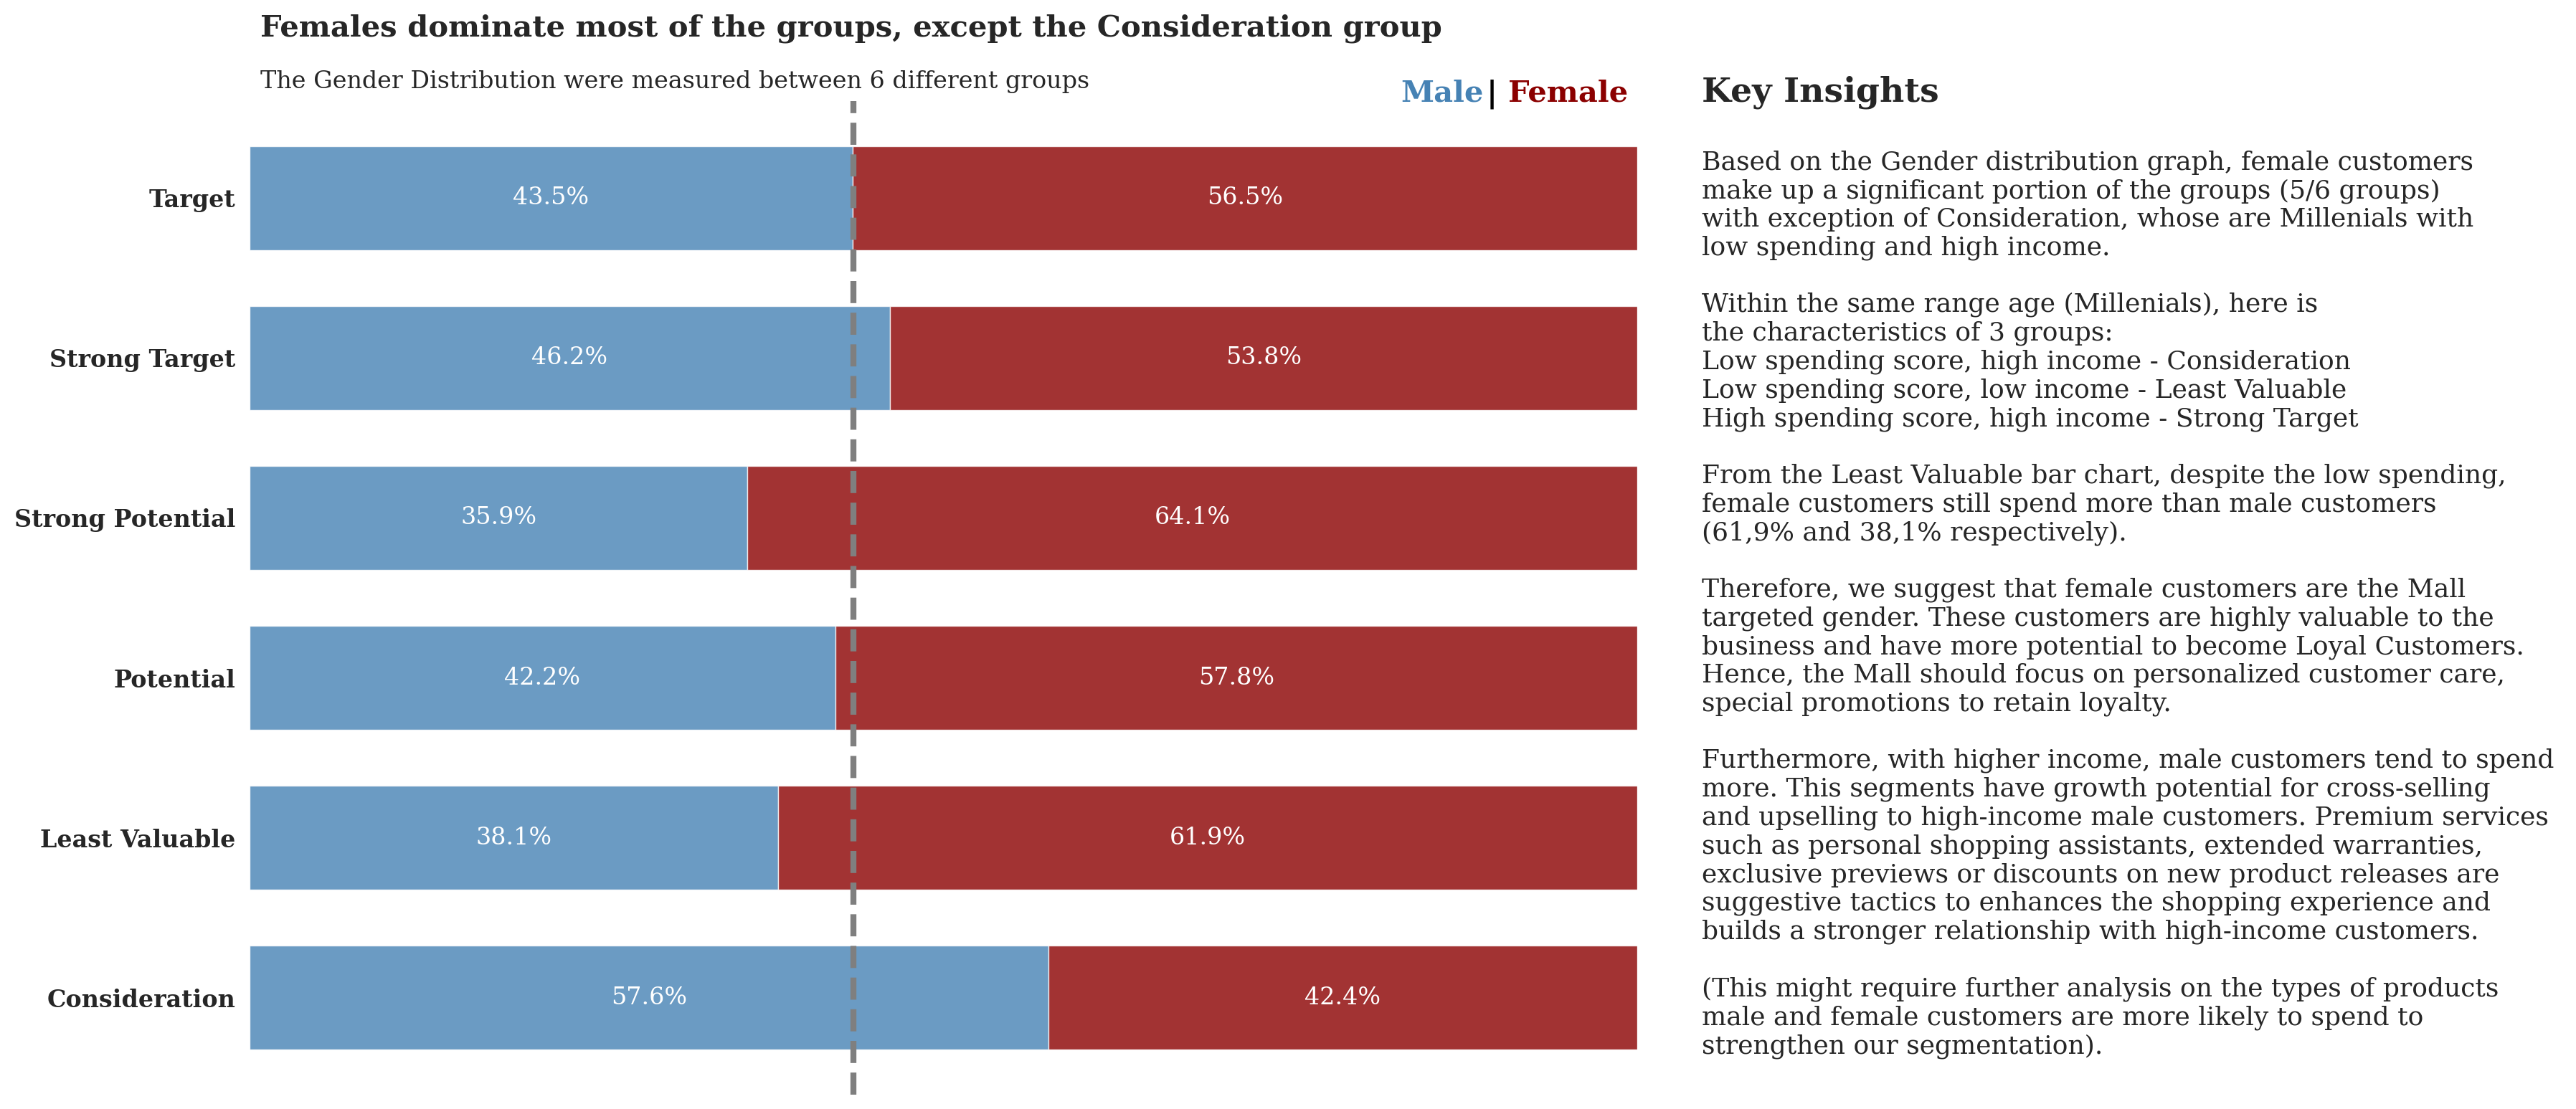

In [138]:
clt_gender = clt_explore[['Clusters_Labels', 'Gender']].groupby('Clusters_Labels')['Gender'].value_counts().unstack().loc[clus_label_order]
clt_gender['sum'] = clt_gender.sum(axis=1)

clt_gender_ratio = (clt_gender.T / clt_gender['sum']).T[['Female', 'Male']].sort_values(by='Clusters_Labels', ascending=False)[::-1]
clt_gender_ratio

####
fig, ax = plt.subplots(1,1,figsize=(15, 9), dpi=200)

ax.barh(clt_gender_ratio.index, clt_gender_ratio['Male'], height=.65,
        color='steelblue', alpha=0.8, label='Male')
ax.barh(clt_gender_ratio.index, clt_gender_ratio['Female'], left=clt_gender_ratio['Male'], height=.65,
        color='darkred', alpha=0.8, label='Female')

fig.text(0.13, 0.93, 'Females dominate most of the groups, except the Consideration group',
         fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.13, 0.89, 'The Gender Distribution were measured between 6 different groups', 
         fontsize=12,fontfamily='serif')   

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(clt_gender_ratio.index, fontfamily='serif', fontsize='large', fontweight='bold')

# male percentage
for i in clt_gender_ratio.index:
    ax.annotate(f"{clt_gender_ratio['Male'][i]*100:.3}%", 
                   xy=(clt_gender_ratio['Male'][i]/2, i),
                   va = 'center', ha='center',fontsize='large', fontweight='light', fontfamily='serif', color='white')

for i in clt_gender_ratio.index:
    ax.annotate(f"{clt_gender_ratio['Female'][i]*100:.3}%", 
                   xy=(clt_gender_ratio['Male'][i]+clt_gender_ratio['Female'][i]/2, i),
                   va = 'center', ha='center',fontsize='large', fontweight='light', fontfamily='serif', color='white')
ax.spines[:].set_visible(False)

fig.text(0.80, 0.88, 'Key Insights', fontsize=17, fontweight='bold', fontfamily='serif')

fig.text(0.80, 0.12, '''Based on the Gender distribution graph, female customers 
make up a significant portion of the groups (5/6 groups) 
with exception of Consideration, whose are Millenials with
low spending and high income.

Within the same range age (Millenials), here is 
the characteristics of 3 groups:
Low spending score, high income - Consideration
Low spending score, low income - Least Valuable
High spending score, high income - Strong Target

From the Least Valuable bar chart, despite the low spending,
female customers still spend more than male customers 
(61,9% and 38,1% respectively). 

Therefore, we suggest that female customers are the Mall 
targeted gender. These customers are highly valuable to the 
business and have more potential to become Loyal Customers. 
Hence, the Mall should focus on personalized customer care, 
special promotions to retain loyalty.

Furthermore, with higher income, male customers tend to spend 
more. This segments have growth potential for cross-selling 
and upselling to high-income male customers. Premium services 
such as personal shopping assistants, extended warranties, 
exclusive previews or discounts on new product releases are 
suggestive tactics to enhances the shopping experience and 
builds a stronger relationship with high-income customers.

(This might require further analysis on the types of products 
male and female customers are more likely to spend to 
strengthen our segmentation).
'''
         , fontsize=13, fontweight='light', fontfamily='serif')
ax.axvline(0.435, ls='--', color='tab:grey', linewidth= 3)
fig.subplots_adjust(wspace=0.05, hspace=.3, right=0.77)
fig.text(0.66,.88,"Male", fontweight="bold", fontfamily='serif', fontsize=15, color='steelblue')
fig.text(0.70,.88,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.71,.88,"Female", fontweight="bold", fontfamily='serif', fontsize=15, color='darkred')
plt.savefig("Clustering/images/groups_gender_barplot", bbox_inches='tight', dpi=300)
plt.show()


In [896]:
clt_gender_ratio['Male'][5]

0.43478260869565216

In [ ]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9)

In [ ]:

from math import pi
def spider_chart(data, title):
     # number of variable
    variables = list(data)[1:]
    N = len(variables)

    # angle of each axis in the plot by dividing the plot / number of variables
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Spider plot
    ax = plt.subplot(3,3,row+1, polar=True)
    plt.xticks(angles[:-1], categories, color='black',fontfamily='serif',fontweight='light', size=8)


    # Tranform values and draw each plot
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    plt.title(title, size=10, fontfamily='serif',fontweight='bold', y=1.2)
    plt.tight_layout()